# 库导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
from sympy import *

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率

# pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 高老师 - 基于技术分析的策略

始于单均线与均线斜率的双信号合成策略，策略仓位为多、平（无仓位）、空。  
后扩展为各类技术指标的检验。  
**高老师策略至2.2为止。**

## 分析函数 - 净值曲线分析与单信号分析

In [2]:
### 分析函数 - 计算各类指标
def Indicator(equity_df,strategy_name):
    '''
    输入净值序列，一列净值，index为日期；策略名称
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    trade_len = (equity_df.index[-1] - equity_df.index[0]).days
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = (cum_return+1)**(365.25/trade_len)-1
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['drawdown'].idxmax()
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df.index<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0].index[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   '累计收益':[cum_return],
                   '年化收益':[mean_return],
                   '年化波动':[vol_return],
                   'IR':[IR],
                   '夏普比率':[sharpe_ratio],
                   '最大回撤':[max_drawdown],
                   '收益回撤比':[mean_return_max_drawdown_ratio],
                   '最大回撤开始':[max_drawdown_start_str],
                   '最大回撤结束':[max_drawdown_end_str],
                   '最大回撤持续':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict,index=[strategy_name]).T
    return output_df, df, df_return_per_year

In [48]:
## 信号质量分析函数
def IndicatorForEachTrade(df):
    '''
    多平空类型的基于技术指标策略专用分析函数，输出净值序列后使用。
    输入dataframe：一列净值，列名为策略名称；一列change，信号变化；一列信号，列名为信号名称
    '''
    DataForKIND_withResult = df.copy()
    ## 计算交易次数，打标签
    cntSignalList = []
    cntSignal = 0
    for eachSignal in DataForKIND_withResult['change'].apply(lambda x: np.nan if x == 0 else x).tolist():
        if eachSignal == 1:
            cntSignalList.append(eachSignal+cntSignal)
            cntSignal += 1
        else:
            cntSignalList.append(eachSignal)
    DataForKIND_withResult['cnt_change'] = cntSignalList
    DataForKIND_withResult['cnt_change'] = DataForKIND_withResult['cnt_change'].fillna(method='ffill')
    DataForKIND_withResult_ = DataForKIND_withResult.dropna().copy()
    ## 计算每次交易评价指标
    cycleList = DataForKIND_withResult_['cnt_change'].unique().tolist()
    CumReurnList = []
    Y_returnList = []
    Y_meanrList = []
    DDList = []
    LastDList = []
    LastTDList = []
    LongOrShort = []
    tolastDDList = []
    tolastDD_LastTList = []
    tolastDD_LastTLists=[]
    tolastDD_LastTListe=[]
    DdaysStartList=[]
    DdaysEndList=[]
    DDendList=[]
    for cyclecnt in cycleList:
        ## 单信号内循环
        if cyclecnt == cycleList[-1]:
            DataForKIND_withResult_tmp1 = DataForKIND_withResult_[DataForKIND_withResult_['cnt_change'] == cyclecnt]
            DataForKIND_withResult_tmp3 = DataForKIND_withResult_tmp1.copy()
        else:
            DataForKIND_withResult_tmp1 = DataForKIND_withResult_[DataForKIND_withResult_['cnt_change'] == cyclecnt]
            DataForKIND_withResult_tmp2 = DataForKIND_withResult_[DataForKIND_withResult_['cnt_change'] == cyclecnt+1].iloc[0,:].to_frame().T
            DataForKIND_withResult_tmp3 = pd.concat([DataForKIND_withResult_tmp1,DataForKIND_withResult_tmp2],axis=0)
        Ddays = (DataForKIND_withResult_tmp3['日期'].tolist()[-1] - DataForKIND_withResult_tmp3['日期'].tolist()[0]).days
        DdaysStart = DataForKIND_withResult_tmp3['日期'].tolist()[0]
        DdaysEnd =  DataForKIND_withResult_tmp3['日期'].tolist()[-1]
        ### 最后一天发生转变信号的情况
        if Ddays == 0:
            continue
        CumReurn = (DataForKIND_withResult_tmp3[strategy_name].tolist()[-1]/DataForKIND_withResult_tmp3[strategy_name].tolist()[0])
    #     Y_return = CumReurn**(365.25/Ddays)-1
    #     Y_meanr = DataForKIND_withResult_tmp3[strategy_name].pct_change().mean()*(252**0.5)
        first_equity = DataForKIND_withResult_tmp3[strategy_name].tolist()[0]
        DD = DataForKIND_withResult_tmp3[strategy_name].apply(lambda x: first_equity/x-1 if first_equity >x else 0).max()
        DDid = DataForKIND_withResult_tmp3[strategy_name].apply(lambda x: first_equity/x-1 if first_equity >x else 0).idxmax()
        try:
            DDend = DataForKIND_withResult_tmp4.loc[DDid,'日期']
        except:
            DDend =DdaysStart

        CumReurnList.append(CumReurn-1)
    #     Y_returnList.append(Y_return)
    #     Y_meanrList.append(Y_meanr)
        DDList.append(DD)
        DDendList.append(DDend)
    #     LastDList.append(Ddays)
    #     LastTDList.append(len(DataForKIND_withResult_tmp3)-1)
        LongOrShort.append(DataForKIND_withResult_tmp3[signal_name].tolist()[0])
        DdaysStartList.append(DdaysStart)
        DdaysEndList.append(DdaysEnd)

        ## 单信号扩展至最后循环
        DataForKIND_withResult_tmp4 = DataForKIND_withResult_[DataForKIND_withResult_['cnt_change'] >= cyclecnt]
        tolast_first_equity = DataForKIND_withResult_tmp4[strategy_name].tolist()[0]
        tolastDD = DataForKIND_withResult_tmp4[strategy_name].apply(lambda x: tolast_first_equity/x-1 if tolast_first_equity>x else 0).max()
        tolastDDid = DataForKIND_withResult_tmp4[strategy_name].apply(lambda x: tolast_first_equity/x-1 if tolast_first_equity>x else 0).idxmax()
        tolastDD_LastT = (DataForKIND_withResult_tmp4.loc[tolastDDid,'日期']-DataForKIND_withResult_tmp4['日期'].tolist()[0]).days
        tolastDD_LastT_end = DataForKIND_withResult_tmp4.loc[tolastDDid,'日期']
#         tolastDD_LastT_start = DataForKIND_withResult_tmp4['日期'].tolist()[0]

        tolastDDList.append(tolastDD)
        tolastDD_LastTList.append(tolastDD_LastT)
#         tolastDD_LastTLists.append(tolastDD_LastT_start)
        tolastDD_LastTListe.append(tolastDD_LastT_end)

    GAO_IndicatorDF = pd.DataFrame({'累计收益':CumReurnList,'信号开始':DdaysStartList,'信号结束':DdaysEndList,
                                    '最大跌幅':DDList,'最大跌幅结束':DDendList,
                                    '方向':LongOrShort,'至末最大跌幅':tolastDDList,'至末最大跌幅持续日':tolastDD_LastTList,
                                    '至末最大跌幅止':tolastDD_LastTListe,
                                   })
    GAO_IndicatorDF['方向'] = GAO_IndicatorDF['方向'].apply(lambda x: '多' if x==1 else '空' if x==-1 else '平' if x==0 else x)
#     GAO_IndicatorDF['R_DD'] = (GAO_IndicatorDF['年化收益']/GAO_IndicatorDF['最大跌幅']).apply(lambda x: np.nan if x==np.inf or x== -np.inf else x)
    return GAO_IndicatorDF

## 回测框架 - 调参专用

### 各类信号
MACOMB为高老师最初多平均线策略  
LNSMA为高老师多平空均线策略

**###################### XXXX系列 ######################  
为可添加部分，可添加新策略，目标为生成信号序列  
同时需添加ADJ1、ADJ2部分内容**

In [4]:
###################### MACOMB系列 ######################
def MACOMBsignal(CloseData, KIND = '沪深300'):
    # 参数读取
    CloseDataForKIND = CloseData[CloseData['品种']==KIND].copy()
    # 信号计算
    ## 单信号计算 - 原材料
    MACOMBwindow_name = 'MACOMB%d'%(MACOMBwindow)
    CloseDataForKIND[MACOMBwindow_name] = CloseDataForKIND['收盘价'].rolling(MACOMBwindow).mean()
    ## 单信号计算 - 整合
    CloseDataForKIND['cross'] = (CloseDataForKIND['收盘价'] - CloseDataForKIND[MACOMBwindow_name]).apply(lambda x: 1 if x>0 else -1 if x<=0 else x)
    CloseDataForKIND['slope'] = (CloseDataForKIND[MACOMBwindow_name] - CloseDataForKIND[MACOMBwindow_name].shift(1)).apply(lambda x: 1 if x>0 else -1 if x<=0 else x)
    ## 信号合并，投票：2多，-2空，0保持原状
    CloseDataForKIND['combine'] = ((CloseDataForKIND['cross'] + CloseDataForKIND['slope'])/2)
    CloseDataForKIND['combine'] = CloseDataForKIND['combine'].apply(lambda x: np.nan if x==0 else x)
    CloseDataForKIND['combine'] = CloseDataForKIND['combine'].fillna(method='ffill')
    CloseDataForKIND['MACOMB%d_signal'%(MACOMBwindow)] = CloseDataForKIND['combine']
    return CloseDataForKIND

In [5]:
###################### MACOMBADJ系列 ######################
def MACOMBADJsignal(CloseData, KIND = '沪深300'):
    # 参数读取
    CloseDataForKIND = CloseData[CloseData['品种']==KIND].copy()
    # 信号计算
    ## 单信号计算 - 原材料
    MACOMBADJwindow_name = 'MACOMBADJ%d'%(MACOMBADJwindow)
    CloseDataForKIND[MACOMBADJwindow_name] = CloseDataForKIND['收盘价'].rolling(MACOMBADJwindow).mean()
    ## 单信号计算 - 整合
    CloseDataForKIND['cross'] = (CloseDataForKIND['收盘价'] - CloseDataForKIND[MACOMBADJwindow_name]).apply(lambda x: 1 if x>0 else -1 if x<=0 else x)
    CloseDataForKIND['slope'] = (CloseDataForKIND[MACOMBADJwindow_name] - CloseDataForKIND[MACOMBADJwindow_name].shift(1)).apply(lambda x: 1 if x>0 else -1 if x<=0 else x)
    ## 信号合并，投票：2多，-2空，0保持不持仓
    CloseDataForKIND['combine'] = ((CloseDataForKIND['cross'] + CloseDataForKIND['slope'])/2)

    CloseDataForKIND['MACOMBADJ%d_signal'%(MACOMBADJwindow)] = CloseDataForKIND['combine']
    return CloseDataForKIND

In [6]:
###################### BBANDS系列 ######################
def BBANDSsignal(CloseData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = CloseData[CloseData['品种'] == KIND].copy()
    ## 指标计算 ##
    BBANDS_result = ta.BBANDS(DataForKIND['收盘价'], timeperiod=BBANDSwindow, nbdevup=nbdev, nbdevdn=nbdev, matype=0)
    DataForKIND['BBANDS_UP_W%dD%d'%(BBANDSwindow,nbdev)] = BBANDS_result[0]
    DataForKIND['BBANDS_DN_W%dD%d'%(BBANDSwindow,nbdev)] = BBANDS_result[2]
    DataForKIND['BBANDS_W%dD%d_signal'%(BBANDSwindow,nbdev)] \
    = DataForKIND.apply(lambda x: 1 if x['收盘价']>x['BBANDS_UP_W%dD%d'%(BBANDSwindow,nbdev)] else -1 if x['收盘价']<x['BBANDS_DN_W%dD%d'%(BBANDSwindow,nbdev)] else 0,axis=1)
    return DataForKIND

In [7]:
###################### MA系列 ######################
def MAsignal(CloseData, KIND = '沪深300'):
    '''
    CloseData, pandas.DataFrame, colnames：['品种','日期','收盘价','开盘价','最高价','最低价'],
    '''
    ## 可选参数设定 ##
    DataForKIND = CloseData[CloseData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['MA%s'%(LongWind)] = DataForKIND['收盘价'].rolling(LongWind).mean()
    DataForKIND['MA%s'%(ShortWind)] = DataForKIND['收盘价'].rolling(ShortWind).mean()
    DataForKIND['MA%s_MA%s'%(ShortWind,LongWind)] = DataForKIND['MA%s'%(ShortWind)]-DataForKIND['MA%s'%(LongWind)]
    DataForKIND['MA%s_MA%s_signal'%(ShortWind,LongWind)] \
    = DataForKIND['MA%s_MA%s'%(ShortWind,LongWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [8]:
###################### COVMA系列 ######################
def COVMAsignal(CloseData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = CloseData[CloseData['品种'] == KIND].copy()
    ## 指标计算 ##
    def ConvComputeMA(series):
        series = list(series)
        seriesDF = pd.DataFrame(series,columns=['series'])
        series_ = seriesDF['series'].pct_change().dropna().tolist()
        series_.reverse()
        pt = series[-1]
        wList = []
        for j in range(COVLongWind-1):
            if j<=COVShortWind-2:
                wList.append(pt*(1/COVShortWind-1/COVLongWind)*(1+j))
            else:
                wList.append(pt/COVLongWind*(COVLongWind-1-j))
        dMA = np.sum([wList[i]*series_[i] for i in range(len(wList))])
        return dMA
    DataForKIND['COVMA%s_COVMA%s'%(COVShortWind,COVLongWind)] = DataForKIND['收盘价'].rolling(COVLongWind).apply(ConvComputeMA,raw=True)
    DataForKIND['COVMA%s_COVMA%s_signal'%(COVShortWind,COVLongWind)] = DataForKIND['COVMA%s_COVMA%s'%(COVShortWind,COVLongWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [9]:
###################### LNSMA系列 ######################
def LNSMAsignal(CloseData, KIND = '沪深300'):
    # 参数读取
    CloseDataForKIND = CloseData[CloseData['品种']==KIND].copy()
    # 信号计算
    ## 单信号计算 - 原材料
    LNSMAwindow_name = 'LNSMA%d'%(LNSMAwindow)
    CloseDataForKIND[LNSMAwindow_name] = CloseDataForKIND['收盘价'].rolling(LNSMAwindow).mean()
    ## 单信号计算 - 整合
    CloseDataForKIND['cross'] = (CloseDataForKIND['收盘价'] - CloseDataForKIND[LNSMAwindow_name]).apply(lambda x: 1 if x>0 else -1 if x<=0 else x)
    CloseDataForKIND['slope'] = (CloseDataForKIND[LNSMAwindow_name] - CloseDataForKIND[LNSMAwindow_name].shift(1)).apply(lambda x: 1 if x>0 else -1 if x<=0 else x)
    ## 信号合并，投票：2多，-2空，0保持原状
    CloseDataForKIND['combine'] = ((CloseDataForKIND['cross'] + CloseDataForKIND['slope'])/2)
    CloseDataForKIND['LNSMA%d_signal'%(LNSMAwindow)] = CloseDataForKIND['combine']
    return CloseDataForKIND

In [10]:
###################### ADJ1 技术指标函数形式统一化 ######################
## 基本信息 ##
def TaFUN(ta):
    FUN = {'MACOMB':MACOMBsignal,
           'MACOMBADJ':MACOMBADJsignal,
           'BBANDS':BBANDSsignal,
           'MA':MAsignal,
           'COVMA':COVMAsignal,
           'LNSMA':LNSMAsignal,
          }
    return FUN[ta]

In [11]:
###################### ADJ2 参数设定+技术指标命名 ######################
## MACOMB ##
(MACOMBwindow) = 60
## MACOMBADJ ##
(MACOMBADJwindow) = 60
## BBANDS ##
(BBANDSwindow,nbdev) = 60, 1.5
## MA ##
(ShortWind,LongWind) = 190, 60
## COVMA ##
(COVShortWind,COVLongWind) = 10, 60
## LNSMA ##
LNSMAwindow = 60

def INDICATOR_nameDICT_FUN(taKIND):
    INDICATOR_nameDICT = {'MACOMB': 'MACOMB%d_signal'%(MACOMBwindow),
                          'MACOMBADJ': 'MACOMBADJ%d_signal'%(MACOMBADJwindow),
                          'BBANDS': 'BBANDS_W%dD%d_signal'%(BBANDSwindow,nbdev),
                          'MA': 'MA%s_MA%s_signal'%(ShortWind,LongWind),
                          'COVMA':'COVMA%s_COVMA%s_signal'%(COVShortWind,COVLongWind),
                          'LNSMA':'LNSMA%d_signal'%(LNSMAwindow),
                         }
    return INDICATOR_nameDICT

### 读取数据

In [42]:
# 读取行情数据
CloseData_ = pd.read_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/均线策略数据库.xlsx')
CloseData = CloseData_[(CloseData_['日期']>=start) & (CloseData_['日期']<=end)]
BenchMark = CloseData[CloseData['品种'] == KIND][['日期','收盘价']].set_index('日期')
BenchMark['收盘价'] = BenchMark['收盘价'].apply(lambda x: x/BenchMark['收盘价'].tolist()[0])

### 策略回测

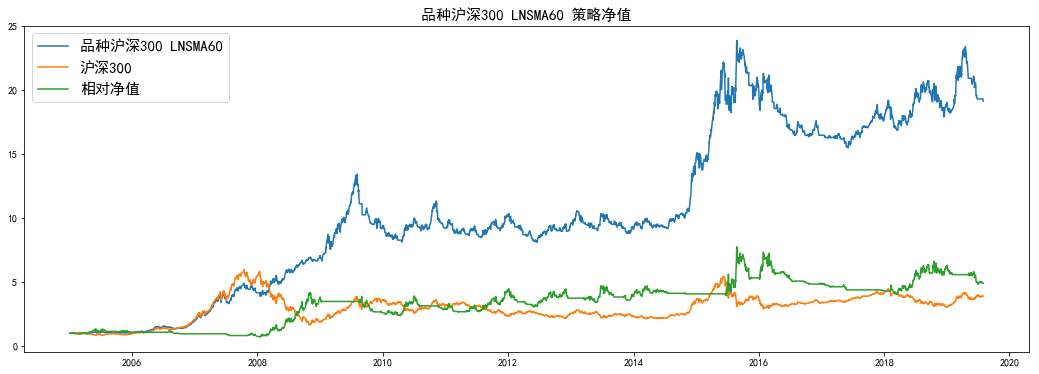

In [54]:
########### 初始化设定 - 可更改 ###########
# 品种 沪深300 美元兑人民币 道琼斯工业指数
KIND = '沪深300'
# 指标
taKIND = 'LNSMA'
# 调参范围与调参对象
MACOMBwindowList = np.arange(60,61)
adjObject = 'LNSMAwindow' # ADJ2中窗口变量名的字符串
# 起止时间点
start = {'沪深300':'2005-01-01',
         '美元兑人民币':'2005-01-01',
         '道琼斯工业指数':'2005-01-01',
        }[KIND]
end = '2019-07-31'
# 是否为调参模式 - 批量调参时不宜画图，会导致运行速度较慢
AdjParams = False

########### 策略回测 - 无需随策略改变而更改 ###########
# 净值评价结果储存字典
Indicator_DICT = {}
# 回测
for Changewindow in MACOMBwindowList:
    ########### 定义窗口变量，运行策略信号计算函数得到信号 ###########
    exec('%s = Changewindow'%(adjObject))
    CloseDataForKIND = TaFUN(taKIND)(CloseData, KIND)
    INDICATOR_nameDICT = INDICATOR_nameDICT_FUN(taKIND)
    ########### 读取信号+行情数据,额外构造信号变换节点指标 ###########
    DataForKIND = CloseDataForKIND.copy()
    signal_name = INDICATOR_nameDICT[taKIND]
    strategy_name = ('品种%s %s'%(KIND,signal_name))[:-7]
    DataForKIND['dprice'] = DataForKIND['收盘价']-DataForKIND['收盘价'].shift(1)
    DataForKIND['change'] = (DataForKIND[signal_name]-DataForKIND[signal_name].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
    ########### 储存各类信息 ###########
    dateList = DataForKIND['日期'].tolist()
    priceList = DataForKIND['收盘价'].tolist()
    signalList = DataForKIND[signal_name].tolist()
    changeList = DataForKIND['change'].tolist()
    dpriceList = DataForKIND['dprice'].tolist()
    ############ 初始化状态 ###########
    equity = 1
    Nshare = 0
    L = 0
    equityList = []
    ############ 循环执行策略 ###########
    for dateCnt in range(len(dateList)):
        ## 更新每日信息
        date = dateList[dateCnt]
        date_last = dateList[dateCnt-1]
        price = priceList[dateCnt]
        dprice = dpriceList[dateCnt]
        combine = signalList[dateCnt]
        change = changeList[dateCnt]
        ## 先结算 - 由于信息每日收盘才能得到！
        dequity = Nshare*dprice*L
        if np.isnan(dequity):
            dequity = 0
        equity += dequity
        equityList.append(equity)
        ## 再根据收盘时发出的信号决定是否改变仓位
        if change == 1:
            L = combine
            Nshare = equity/price
    equityDf_KIND = pd.DataFrame({'日期':dateList,'%s' %(strategy_name):equityList}).set_index('日期')
    DataForKIND_withResult = DataForKIND.merge(pd.DataFrame({'日期':dateList,'%s' %(strategy_name):equityList}),on=['日期'])
    ########### 结果输出 ############
    ## 净值曲线 ##
    if not AdjParams:
        plt.figure(figsize=(18,6))
        plt.plot(equityDf_KIND,label='%s'%(strategy_name))
        plt.plot(BenchMark,label='%s'%(KIND))
        plt.plot(equityDf_KIND[strategy_name]/BenchMark['收盘价'],label='相对净值')
        plt.title('%s'%(strategy_name)+' 策略净值',fontsize=15)
        plt.legend(loc=0,fontsize=15)
        plt.show()
    ## 净值评价指标 ##
    ### 经典指标 ###
    Indicator_DF_each = Indicator(equityDf_KIND,'%s'%(strategy_name))[0]
    ### 新指标 ###
    IndicatorForEach_DF = IndicatorForEachTrade(DataForKIND_withResult)
    cumY_cumDD = Indicator_DF_each.loc['累计收益',][0]/IndicatorForEach_DF['最大跌幅'].sum()
    maxDD = IndicatorForEach_DF['最大跌幅'].max()
    maxToEndDD = IndicatorForEach_DF['至末最大跌幅'].max()
    maxToEndDDs = IndicatorForEach_DF.loc[IndicatorForEach_DF['至末最大跌幅'].idxmax(),'信号开始']
    maxToEndDDe = IndicatorForEach_DF.loc[IndicatorForEach_DF['至末最大跌幅'].idxmax(),'至末最大跌幅止']
    yR_avgDD = Indicator_DF_each.loc['年化收益',][0]/IndicatorForEach_DF['最大跌幅'].mean()
    New_Indicator = pd.DataFrame([KIND,taKIND,Changewindow,cumY_cumDD,maxDD,maxToEndDD,maxToEndDDe]
                                 ,index=['品种','指标','窗口','cumR_cumDD','maxDD','最大至末跌幅','最大至末跌幅止']
                                 ,columns=[strategy_name])
    ### 指标合并 ###
    All_Indicator = pd.concat([New_Indicator, Indicator_DF_each],axis=0)
    Indicator_DICT[strategy_name] = All_Indicator

In [95]:
## 单次结果输出 - 单信号评价指标
IndicatorForEach_DF.to_excel('C:/Users/Thinkpad\Desktop/多平空均线策略%s_窗口%d单信号评价指标.xlsx'%(KIND,LNSMAwindow))

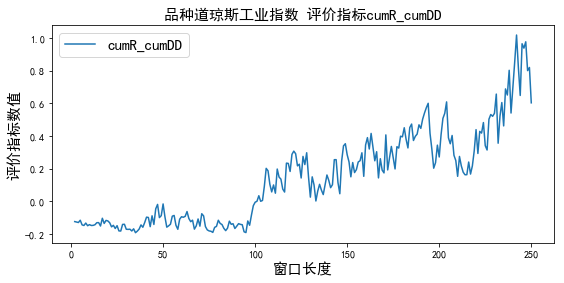

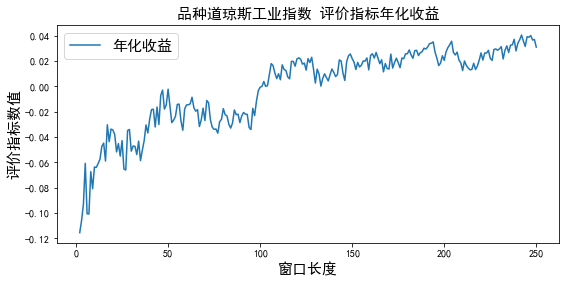

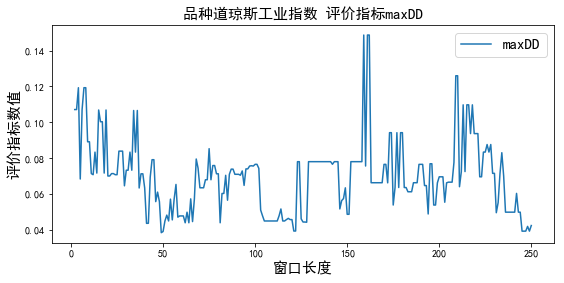

In [88]:
## 多次结果输出 - 参数-策略评价指标
Indicator_DF = pd.DataFrame()
for strategy_name in Indicator_DICT.keys():
    Indicator_DF = pd.concat([Indicator_DF,Indicator_DICT[strategy_name]],axis=1)
for indicator_used in ['cumR_cumDD','年化收益','maxDD']:
    plt.figure(figsize=(9,4))
    plt.title('品种%s 评价指标%s'%(KIND,indicator_used),fontsize=15)
    plt.plot(Indicator_DF.loc['窗口',].tolist(), Indicator_DF.loc[indicator_used,].tolist(),label=indicator_used)
    plt.legend(loc=0,fontsize=15)
    plt.xlabel('窗口长度',fontsize=15)
    plt.ylabel('评价指标数值',fontsize=15)
    plt.show()

In [89]:
## 最优结果评价指标
Indicator_DF.iloc[:,np.argmax(Indicator_DF.T['年化收益'].tolist())].to_frame()

,品种道琼斯工业指数 LNSMA242
品种,道琼斯工业指数
指标,LNSMA
窗口,242
cumR_cumDD,1.01864
maxDD,0.0604628
最大至末跌幅,0.220412
最大至末跌幅起,2015-07-08 00:00:00
最大至末跌幅止,2016-07-05 00:00:00
累计收益,0.784726
年化收益,0.0405636


In [90]:
## 指定窗口的净值评价指标
Indicator_DF.T[Indicator_DF.T['窗口'].isin([238,239,240,241,242])].T

,品种道琼斯工业指数 LNSMA238,品种道琼斯工业指数 LNSMA239,品种道琼斯工业指数 LNSMA240,品种道琼斯工业指数 LNSMA241,品种道琼斯工业指数 LNSMA242
品种,道琼斯工业指数,道琼斯工业指数,道琼斯工业指数,道琼斯工业指数,道琼斯工业指数
指标,LNSMA,LNSMA,LNSMA,LNSMA,LNSMA
窗口,238,239,240,241,242
cumR_cumDD,0.802607,0.540803,0.695994,0.854129,1.01864
maxDD,0.0500116,0.0500116,0.0500116,0.0500116,0.0604628
最大至末跌幅,0.290774,0.280214,0.298047,0.260241,0.220412
最大至末跌幅起,2010-05-26 00:00:00,2010-05-26 00:00:00,2010-05-26 00:00:00,2015-07-08 00:00:00,2015-07-08 00:00:00
最大至末跌幅止,2012-07-24 00:00:00,2012-06-11 00:00:00,2012-06-11 00:00:00,2016-11-04 00:00:00,2016-07-05 00:00:00
累计收益,0.701715,0.49546,0.629086,0.694956,0.784726
年化收益,0.0371672,0.0280094,0.0340665,0.0368839,0.0405636


### 其他结果输出

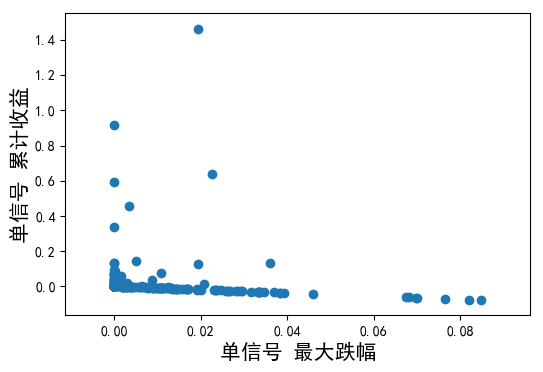

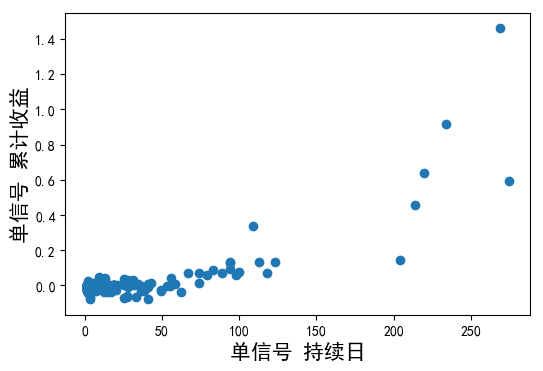

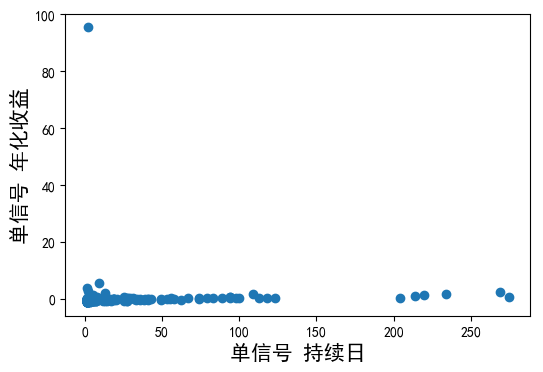

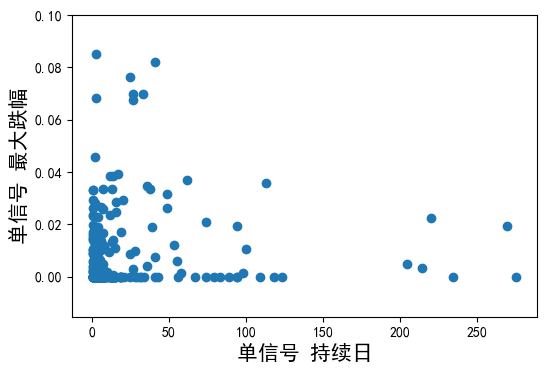

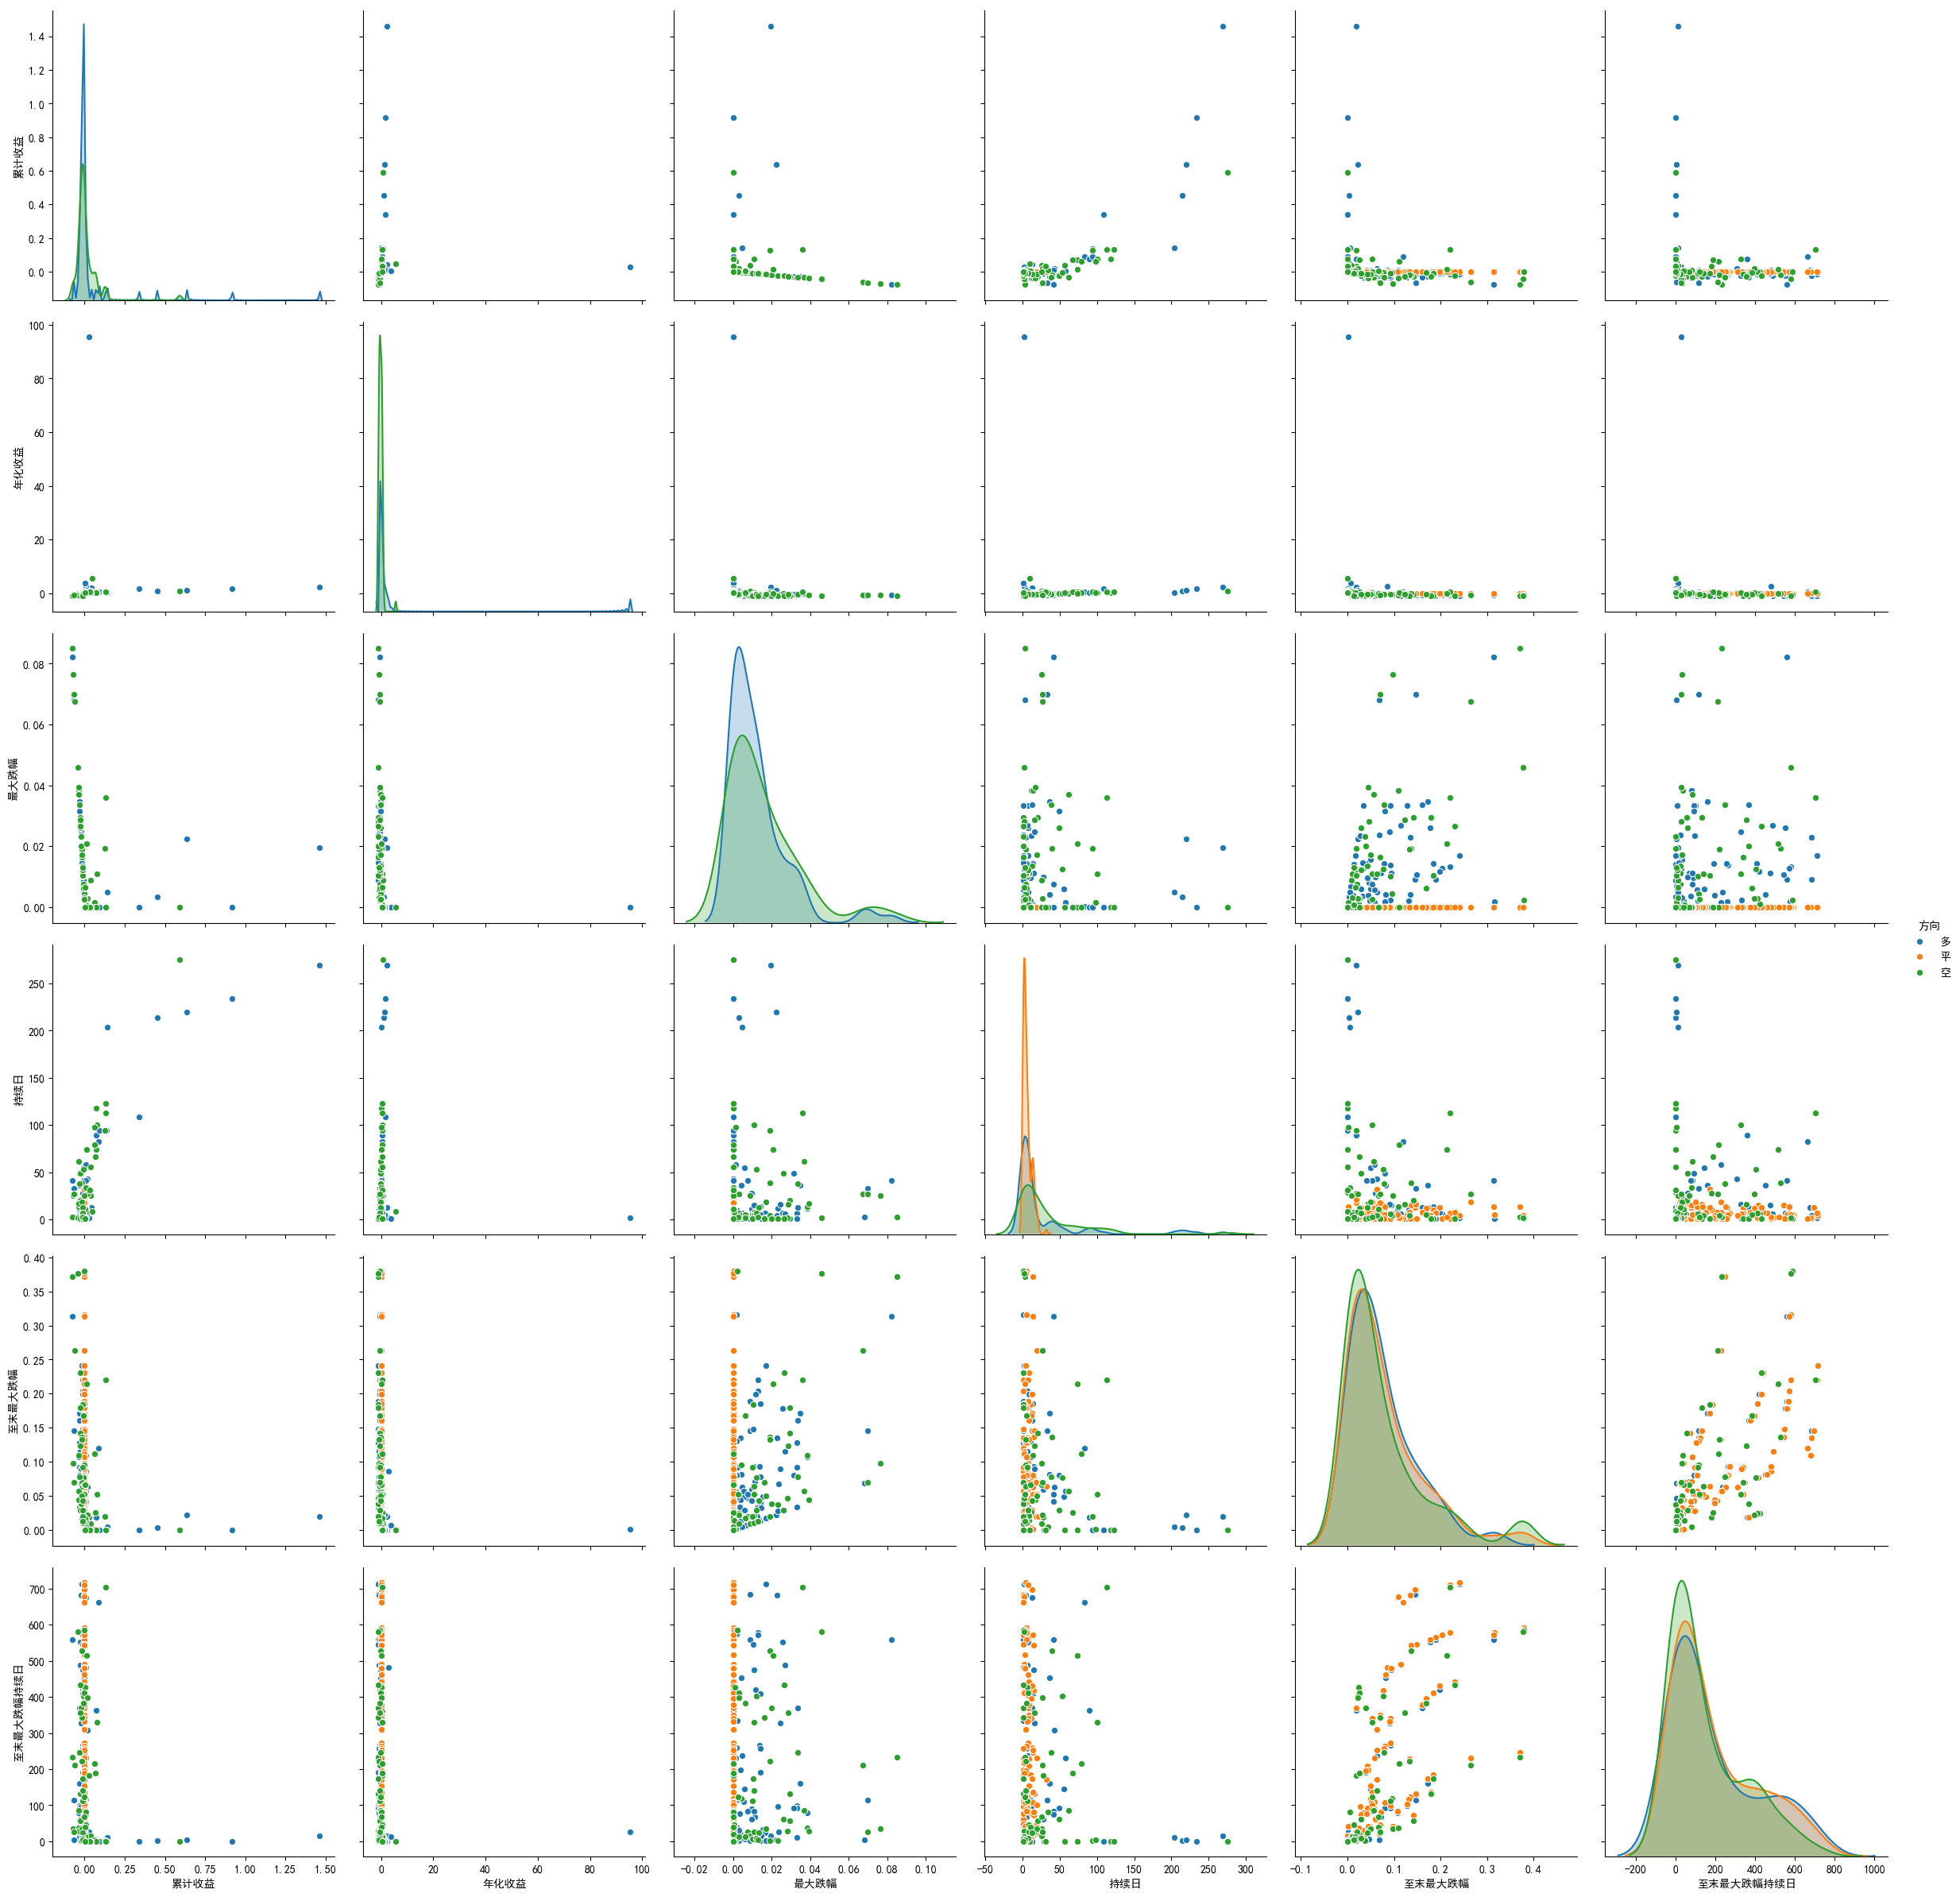

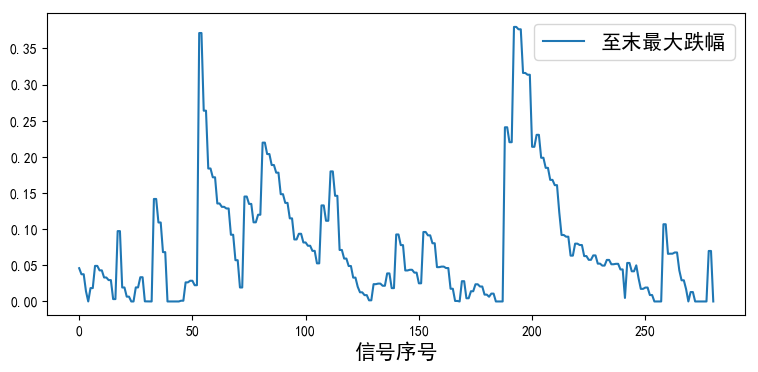

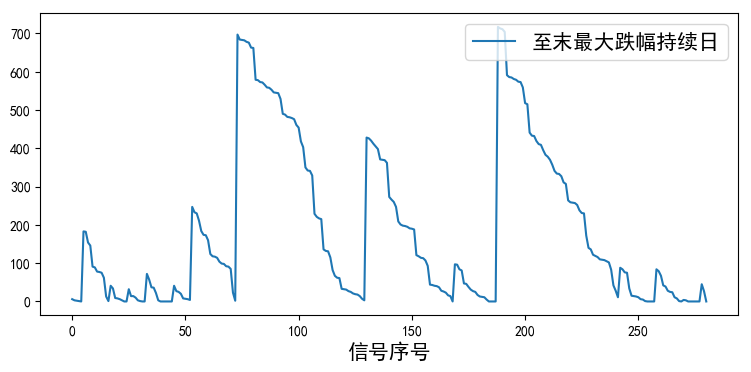

In [244]:
## 单次结果输出 - 散点图
for axis_name in [['最大跌幅','累计收益'],['持续日','累计收益'],['持续日','年化收益'],['持续日','最大跌幅'],]:
    X_name, y_name = axis_name[0], axis_name[1]
    plt.figure(figsize=(6,4))
    fontsize = 15
    plt.scatter(IndicatorForEach_DF[X_name],IndicatorForEach_DF[y_name])
    plt.xlabel('单信号 %s'%(X_name),fontsize=fontsize)
    plt.ylabel('单信号 %s'%(y_name),fontsize=fontsize)
    plt.show()
IndicatorForEach_DF
pairplot_gg = seaborn.pairplot(IndicatorForEach_DF[[col for col in IndicatorForEach_DF.columns if col not in ['持续交易日','年化平均收益']]],height=4,hue='方向')
plt.show()
## 单次结果输出 - 信号评价指标时间序列
for coll in ['至末最大跌幅','至末最大跌幅持续日']:
    plt.figure(figsize=(9,4))
    plt.plot(IndicatorForEach_DF[coll],label=coll)
    plt.xlabel('信号序号',fontsize=15)
    plt.legend(loc=0,fontsize=15)
    plt.show()

## 回测框架 - 双参数调整

In [485]:
########### 初始化设定 ###########
Indicator_DICT = {}

# 品种 沪深300 美元兑人民币 道琼斯工业指数
KIND = '道琼斯工业指数'

# 指标
taKIND = 'MA'

# 指标保存
BEGINwind = 2
ENDwind = 401
IndicatorSaveDf = pd.DataFrame(index = range(BEGINwind,ENDwind),columns = range(BEGINwind+1,ENDwind+1))

# 起止时间点
start = {'沪深300':'2005-01-01',
         '美元兑人民币':'2005-01-01',
         '道琼斯工业指数':'2005-01-01',
        }[KIND]
end = '2019-07-31'

CloseData = CloseData_[(CloseData_['日期']>=start) & (CloseData_['日期']<=end)]

## 计时器 - 始
time_cost = 0
time_cnt = 0
for Changewindow in np.arange(BEGINwind,ENDwind):
    for Changewindow_ in np.arange(Changewindow+1,ENDwind+1):
    
        ## 需要更改，窗口定义变量
        ShortWind = Changewindow
        LongWind = Changewindow_

        CloseDataForKIND = TaFUN(taKIND)(CloseData, KIND)
        INDICATOR_nameDICT = INDICATOR_nameDICT_FUN(taKIND)

        t_start = datetime.datetime.now()
        ########### 读取信号+行情数据,额外构造信号变换节点指标 ###########
        DataForKIND = CloseDataForKIND.copy()
        signal_name = INDICATOR_nameDICT[taKIND]
        strategy_name = ('品种%s %s'%(KIND,signal_name))[:-7]
        DataForKIND['dprice'] = DataForKIND['收盘价']-DataForKIND['收盘价'].shift(1)
        DataForKIND['change'] = (DataForKIND[signal_name]-DataForKIND[signal_name].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
        ########### 储存各类信息 ###########
        dateList = DataForKIND['日期'].tolist()
        priceList = DataForKIND['收盘价'].tolist()
        signalList = DataForKIND[signal_name].tolist()
        changeList = DataForKIND['change'].tolist()
        dpriceList = DataForKIND['dprice'].tolist()
        ############ 初始化状态 ###########
        equity = 1
        Nshare = 0
        L = 0
        equityList = []
        ############ 循环执行策略 ###########
        for dateCnt in range(len(dateList)):
            ## 更新每日信息
            date = dateList[dateCnt]
            date_last = dateList[dateCnt-1]
            price = priceList[dateCnt]
            dprice = dpriceList[dateCnt]
            combine = signalList[dateCnt]
            change = changeList[dateCnt]
            ## 先结算 - 由于信息每日收盘才能得到！
            dequity = Nshare*dprice*L
            if np.isnan(dequity):
                dequity = 0
            equity += dequity
            equityList.append(equity)
            ## 再根据收盘时发出的信号决定是否改变仓位
            if change == 1:
                L = combine
                Nshare = equity/price
        equityDf_KIND = pd.DataFrame({'日期':dateList,'%s' %(strategy_name):equityList}).set_index('日期')
        DataForKIND_withResult = DataForKIND.merge(pd.DataFrame({'日期':dateList,'%s' %(strategy_name):equityList}),on=['日期'])
        ########### 结果输出 ############
        # 年化收益率
        cum_return = equityDf_KIND[strategy_name][-1]/equityDf_KIND[strategy_name][0]-1
        trade_len = (equityDf_KIND.index[-1] - equityDf_KIND.index[0]).days
        mean_return = (cum_return+1)**(365.25/trade_len)-1
        IndicatorSaveDf.loc[ShortWind,LongWind] = mean_return

        ## 计时器 - 终
        time_cnt += 1
        t_end = datetime.datetime.now()
        seconds = (t_end-t_start).microseconds/1000000
        time_cost += seconds
        print('%.5f %.5f'%(seconds, time_cost/time_cnt),end='\r')

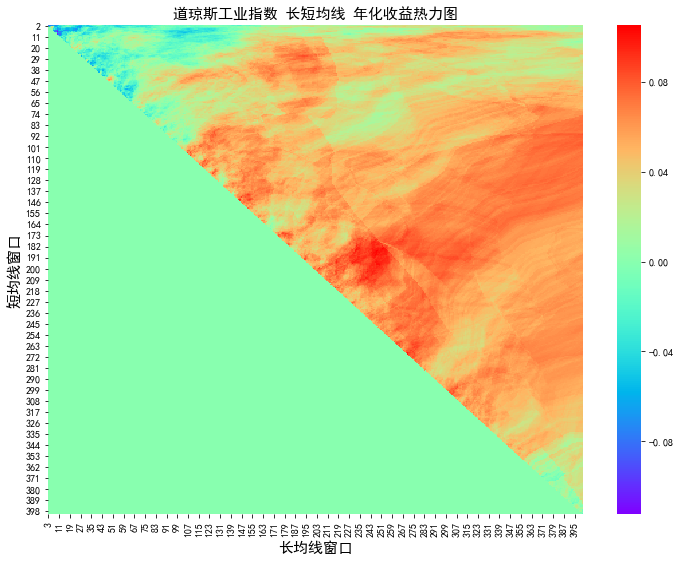

In [486]:
plt.figure(figsize=(12,9))
seaborn.heatmap(IndicatorSaveDf.fillna(0),cmap='rainbow')
plt.xlabel('长均线窗口',fontsize=15)
plt.ylabel('短均线窗口',fontsize=15)
plt.title('%s 长短均线 年化收益热力图'%(KIND),fontsize=15)
plt.show()

# 沪深300 - 技术指标策略 MA、MACD、RSI、SAR等

## 专用净值评价函数

In [43]:
### 分析函数 - 计算各类指标
def Indicator(equity_df,strategy_name):
    '''
    输入净值序列，一列净值，index为日期；策略名称
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    trade_len = (equity_df.index[-1] - equity_df.index[0]).days
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = (cum_return+1)**(365.25/trade_len)-1
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['drawdown'].idxmax()
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df.index<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0].index[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   '年化收益':[mean_return],
                   '年化波动':[vol_return],
                   'IR':[IR],
                   '夏普比率':[sharpe_ratio],
                   '最大回撤':[max_drawdown],
                   '收益回撤比':[mean_return_max_drawdown_ratio],
                   '最大回撤开始':[max_drawdown_start_str],
                   '最大回撤结束':[max_drawdown_end_str],
                   '最大回撤持续':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict,index=[strategy_name]).T
    return output_df, df, df_return_per_year

## 数据导入

In [44]:
###################### 初始化设定 - 品种+日期&收盘价序列 ######################
## 数据导入 ##
PriceData_ = pd.read_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/均线策略数据库-四类价格.xlsx')
## 起止时间点 ##
start = '2005-01-01'
end = '2019-07-31'
PriceData = PriceData_[(PriceData_['日期']>=start) & (PriceData_['日期']<=end)]
## 品种选择 ##
# KIND = '沪深300'

## 技术指标计算

In [45]:
###################### MA系列 ######################
def MAsignal(PriceData, KIND = '沪深300'):
    '''
    PriceData, pandas.DataFrame, colnames：['品种','日期','收盘价','开盘价','最高价','最低价'],
    '''
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['MA%s'%(LongWind)] = DataForKIND['收盘价'].rolling(LongWind).mean()
    DataForKIND['MA%s'%(ShortWind)] = DataForKIND['收盘价'].rolling(ShortWind).mean()
    DataForKIND['MA%s_MA%s'%(ShortWind,LongWind)] = DataForKIND['MA%s'%(ShortWind)]-DataForKIND['MA%s'%(LongWind)]
    DataForKIND['MA%s_MA%s_signal'%(ShortWind,LongWind)] \
    = DataForKIND['MA%s_MA%s'%(ShortWind,LongWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [46]:
###################### MACD系列 ######################
def MACDsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['DI'] = DataForKIND['最高价']*0.25 + DataForKIND['最低价']*0.25 + DataForKIND['收盘价']*0.5
    ### 算法1 ###
#     DataForKIND['EMA%d'%(FastWind)] = DataForKIND['DI'].ewm(span=FastWind,adjust=False,min_periods=FastWind).mean()
#     DataForKIND['EMA%d'%(SlowWind)] = DataForKIND['DI'].ewm(span=SlowWind,adjust=False,min_periods=SlowWind).mean()
#     DataForKIND['DIF'] = DataForKIND['EMA%d'%(FastWind)] - DataForKIND['EMA%d'%(SlowWind)]
#     DataForKIND['MACD'] = DataForKIND['DIF'].ewm(span=SignalWind,adjust=False,min_periods=SignalWind).mean()
    ### 算法2 ###
    DataForKIND['DIF'] = ta.MACD(DataForKIND['DI'],FastWind,SlowWind,SignalWind)[0]
    DataForKIND['MACD'] = ta.MACD(DataForKIND['DI'],FastWind,SlowWind,SignalWind)[1]
    
    DataForKIND['DminusF_F%dS%dSig%d'%(FastWind,SlowWind,SignalWind)] = DataForKIND['DIF'] - DataForKIND['MACD']
    DataForKIND['DminusF_F%d_S%d_Sig%d_signal'%(FastWind,SlowWind,SignalWind)] \
    = DataForKIND['DminusF_F%dS%dSig%d'%(FastWind,SlowWind,SignalWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [47]:
###################### RSI系列 ######################
def RSIsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['RSI_%d'%(ShortRsiWind)] = ta.RSI(DataForKIND['收盘价'], timeperiod=ShortRsiWind)
    DataForKIND['RSI_%d'%(LongRsiWind)] = ta.RSI(DataForKIND['收盘价'], timeperiod=LongRsiWind)
    DataForKIND['dRSI_%d_%d'%(ShortRsiWind,LongRsiWind)] \
    = DataForKIND['RSI_%d'%(ShortRsiWind)] - DataForKIND['RSI_%d'%(LongRsiWind)]
    DataForKIND['dRSI_S%d_L%d_signal'%(ShortRsiWind,LongRsiWind)] \
    = DataForKIND['dRSI_%d_%d'%(ShortRsiWind,LongRsiWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [48]:
###################### SAR系列 ######################
def SARsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['SAR_AF%.2fto%.1f'%(AF,AF_max)] \
    = ta.SAR(DataForKIND['最高价'], DataForKIND['最低价'], acceleration=AF, maximum=AF_max)
    DataForKIND['close_SAR_AF%.2fto%.1f'%(AF,AF_max)] \
    = DataForKIND['收盘价'] - DataForKIND['SAR_AF%.2fto%.1f'%(AF,AF_max)]
    DataForKIND['SAR_AF%.2fto%.1f_signal'%(AF,AF_max)] \
    = DataForKIND['close_SAR_AF%.2fto%.1f'%(AF,AF_max)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [49]:
###################### BBANDS系列 ######################
def BBANDSsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    BBANDS_result = ta.BBANDS(DataForKIND['收盘价'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=0)
    DataForKIND['BBANDS_UP_W%dD%d'%(timeperiod,nbdev)] = BBANDS_result[0]
    DataForKIND['BBANDS_DN_W%dD%d'%(timeperiod,nbdev)] = BBANDS_result[2]
    DataForKIND['BBANDS_W%dD%d_signal'%(timeperiod,nbdev)] \
    = DataForKIND.apply(lambda x: 1 if x['收盘价']>x['BBANDS_UP_W%dD%d'%(timeperiod,nbdev)] else -1 if x['收盘价']<x['BBANDS_DN_W%dD%d'%(timeperiod,nbdev)] else 0,axis=1)
    return DataForKIND

In [50]:
###################### EMA系列 ######################
def EMAsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['EMA%d'%(eFastWind)] = DataForKIND['收盘价'].ewm(span=FastWind,adjust=False,min_periods=FastWind).mean()
    DataForKIND['EMA%d'%(eSlowWind)] = DataForKIND['收盘价'].ewm(span=eSlowWind,adjust=False,min_periods=eSlowWind).mean()
    DataForKIND['EMA%d_EMA%d'%(eFastWind,eSlowWind)] = DataForKIND['EMA%d'%(eFastWind)] - DataForKIND['EMA%d'%(eSlowWind)]
    DataForKIND['EMA%d_EMA%d_signal'%(eFastWind,eSlowWind)] = DataForKIND['EMA%d_EMA%d'%(eFastWind,eSlowWind)].apply(lambda x: 1 if x>0 else -1 if x< 0 else 0)
    return DataForKIND

In [51]:
###################### WILLR系列 ######################
def WILLRsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['WILLR_H'] = DataForKIND['最高价'].rolling(WILLRwind).max()
    DataForKIND['WILLR_L'] = DataForKIND['最低价'].rolling(WILLRwind).min()
    DataForKIND['WILLR%d'%(WILLRwind)] = (DataForKIND['WILLR_H']-DataForKIND['收盘价'])/(DataForKIND['WILLR_H']-DataForKIND['WILLR_L'])*100
    DataForKIND['WILLR%d_signal'%(WILLRwind)] = DataForKIND['WILLR%d'%(WILLRwind)].apply(lambda x: 1 if x>80 else -1 if x< 20 else 0)
    return DataForKIND
###################### WILLRK系列 ######################
def WILLRKsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['WILLRK_H'] = DataForKIND['成交额'].rolling(WILLRKwind).max()
    DataForKIND['WILLRK_L'] = DataForKIND['成交额'].rolling(WILLRKwind).min()
    DataForKIND['WILLRK_M'] = DataForKIND['成交额'].rolling(WILLRKwind).mean()
    DataForKIND['WILLRK%d'%(WILLRKwind)] = (DataForKIND['成交额']-0.5*DataForKIND['WILLRK_M'])/(DataForKIND['WILLRK_H']-DataForKIND['WILLRK_L'])*2
    DataForKIND['WILLRK%d_signal'%(WILLRKwind)] = DataForKIND['WILLRK%d'%(WILLRKwind)].apply(lambda x: -1 if x>4 else 1 if x< 0.4 else 0)
    return DataForKIND

In [52]:
###################### CCI系列 ######################
def CCIsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['CCI%d'%(CCIwind)] = ta.CCI(DataForKIND['最高价'], DataForKIND['最低价'], DataForKIND['收盘价'], timeperiod=CCIwind)
    CCIList = DataForKIND['CCI%d'%(CCIwind)].tolist()
    CCI_signalList = []
    for CCIeachN in range(len(CCIList)):
        CCIeach = CCIList[CCIeachN]
        if np.isnan(CCIeach):
            CCI_signalList.append(CCIeach)
            continue
        ## 第一个信号，特殊处理
        LCCIeach = CCIList[CCIeachN-1]
        if np.isnan(LCCIeach):
            if CCIeach > 100:
                CCI_signalList.append(1)
            elif CCIeach <= 100 and CCIeach >= 0:
                CCI_signalList.append(0)
            elif CCIeach < 0:
                CCI_signalList.append(-1)
            continue
        ## 非第一个信号
        ### 上穿做多
        if (LCCIeach<0 and CCIeach>0) or (LCCIeach<-100 and CCIeach>-100) or (LCCIeach<100 and CCIeach>100):
            CCI_signalList.append(1)
        ### 下穿做空
        elif (LCCIeach>0 and CCIeach<0) or (LCCIeach>-100 and CCIeach<-100) or (LCCIeach>100 and CCIeach<100):
            CCI_signalList.append(-1)
        ### 不穿则保持之前状态
        else:
            CCI_signalList.append(CCI_signalList[CCIeachN-1])
    DataForKIND['CCI%d_signal'%(CCIwind)] = CCI_signalList
    return DataForKIND
###################### CCIEX系列 ######################
def CCIEXsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['CCIEX%d'%(CCIEXwind)] = ta.CCI(DataForKIND['最高价'], DataForKIND['最低价'], DataForKIND['收盘价'], timeperiod=CCIEXwind)
    DataForKIND['CCIEX%d_signal'%(CCIEXwind)] = DataForKIND['CCIEX%d'%(CCIEXwind)].apply(lambda x: 1 if x > 100 else -1 if x < -100 else 0)
    return DataForKIND

In [53]:
###################### COMB系列 ######################
# TrendIndicator = ['MA','MACD','RSI','SAR','EMA']
# InverseIndicator = ['BBANDS']
# COMBway, COMBhow = 'Trend', 'any'
def COMBsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    PriceData = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND_all = pd.DataFrame()
    if COMBway == 'Trend':
        IndicatorList = TrendIndicator
    elif COMBway == 'Inverse':
        IndicatorList = InverseIndicator
    for taKKIND in IndicatorList:
        DataForKIND_tmp = TaFUN(taKKIND)(PriceData, KIND)
        DataForKIND_tmp_ = DataForKIND_tmp[['日期',INDICATOR_nameDICT[taKKIND]]].set_index('日期').copy()
        DataForKIND_all = pd.concat([DataForKIND_all,DataForKIND_tmp_],axis=1)
    if COMBhow == 'all':
        threshold = len(IndicatorList)
    elif COMBhow == 'any':
        threshold = 1
    elif COMBhow == 'partly':
        threshold = len(IndicatorList)/3
    DataForKIND = DataForKIND_all.sum(axis=1).apply(lambda x: 
                                                    1 if x >= threshold else 
                                                    -1 if x <= -threshold else 
                                                    0).to_frame('COMB_%s_%s_signal'%(COMBway,COMBhow))
    DataForKIND = PriceData.merge(DataForKIND.reset_index(),on=['日期'])
    return DataForKIND

## 回测框架 - 批量测试单指标

In [54]:
###################### ADJ1 技术指标函数形式统一化 ######################
## 基本信息 ##
def TaFUN(ta):
    FUN = {'MA':MAsignal,
           'MACD':MACDsignal,
           'RSI':RSIsignal,
           'SAR':SARsignal,
           'BBANDS':BBANDSsignal,
           'EMA':EMAsignal,
           'WILLR':WILLRsignal,
           'WILLRK':WILLRKsignal,
           'CCI':CCIsignal,
           'CCIEX':CCIEXsignal,
           
           'COMB':COMBsignal,
          }
    return FUN[ta]

In [55]:
###################### ADJ2 参数设定+技术指标命名 ######################
## MA ##
(ShortWind,LongWind) = 5, 60
## MACD ##
(FastWind,SlowWind,SignalWind) = 12, 26, 9
## RSI ##
(ShortRsiWind,LongRsiWind) = 6, 24
## SAR ##
(AF,AF_max) = 0.02, 0.2
## BBANDS ##
(timeperiod,nbdev) = 10, 2
## EMA ##
(eFastWind,eSlowWind) = 5, 60
## WILLR ##
WILLRwind = 15
## WILLRK ##
WILLRKwind = 15
## CCI ##
CCIwind = 24
## CCIEX ##
CCIEXwind = 24

INDICATOR_nameDICT = {'MA':   'MA%s_MA%s_signal'%(ShortWind,LongWind),
                      'MACD': 'DminusF_F%d_S%d_Sig%d_signal'%(FastWind,SlowWind,SignalWind),
                      'RSI':  'dRSI_S%d_L%d_signal'%(ShortRsiWind,LongRsiWind),
                      'SAR':  'SAR_AF%.2fto%.1f_signal'%(AF,AF_max),
                      'BBANDS': 'BBANDS_W%dD%d_signal'%(timeperiod,nbdev),
                      'EMA': 'EMA%d_EMA%d_signal'%(eFastWind,eSlowWind),
                      'WILLR': 'WILLR%d_signal'%(WILLRwind),
                      'WILLRK':'WILLRK%d_signal'%(WILLRKwind),
                      'CCI': 'CCI%d_signal'%(CCIwind),
                      'CCIEX': 'CCIEX%d_signal'%(CCIEXwind),
                     }

In [56]:
###################### ADJ3 技术指标选择并回测 ######################
Indicator_Dict = {}
KINDList = ['沪深300','中证500','上证综指']
# taKINDList = ['MA','MACD','RSI','SAR']
taKINDList = ['MA','MACD','RSI','SAR','BBANDS','EMA','WILLR','WILLRK','CCI','CCIEX']
for KIND in KINDList:
    for taKIND in taKINDList:
        INDICATOR_used = taKIND
        ######################## 回测 ########################
        ###################### 指标转换接入回测 ######################
        DataForKIND = TaFUN(INDICATOR_used)(PriceData,KIND)
        INDICATOR = INDICATOR_nameDICT[INDICATOR_used]
        DataForKIND_S = DataForKIND.copy()
        DataForKIND_S['Signal'] = DataForKIND_S[INDICATOR]
        DataForKIND_S['dprice'] = DataForKIND_S['收盘价']-DataForKIND_S['收盘价'].shift(1)
        DataForKIND_S['change'] = (DataForKIND_S['Signal'] - DataForKIND_S['Signal'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
        ###################### 储存各类信息 ######################
        dateList = DataForKIND_S['日期'].tolist()
        priceList = DataForKIND_S['收盘价'].tolist()
        combineList = DataForKIND_S['Signal'].tolist()
        changeList = DataForKIND_S['change'].tolist()
        dpriceList = DataForKIND_S['dprice'].tolist()
        ####################### 初始化状态 ######################
        equity = 1
        Nshare = 0
        L = 0
        equityList = []
        ####################### 日循环执行策略 ######################
        strategy_name = ('品种%s 指标%s'%(KIND,INDICATOR))[:-7]
        for dateCnt in range(len(dateList)):
            ## 更新每日信息
            date = dateList[dateCnt]
            date_last = dateList[dateCnt-1]
            price = priceList[dateCnt]
            dprice = dpriceList[dateCnt]
            combine = combineList[dateCnt]
            change = changeList[dateCnt]
            ## 先结算 - 由于信息每日收盘才能得到！
            dequity = Nshare*dprice*L
            if np.isnan(dequity):
                dequity = 0
            equity += dequity
            equityList.append(equity)
            ## 再根据收盘时发出的信号决定是否改变仓位
            if change == 1:
                L = combine
                Nshare = equity/price
        ####################### 回测结果保存 ######################
        equityDf_KIND = pd.DataFrame({'日期':dateList,strategy_name:equityList}).set_index('日期')
        DataForKIND_S_withResult = DataForKIND_S.merge(pd.DataFrame({'日期':dateList,strategy_name:equityList}),on=['日期'])
        ####################### 结果输出 ######################
        # 绘图 #
#         ## 净值曲线 ##
#         plt.figure(figsize=(15,8))
#         plt.plot(equityDf_KIND,label='%s策略净值' %(INDICATOR_used))
#         plt.title('%s 回测时间%s-%s 策略净值' %(strategy_name,start,end),fontsize=15)
#         plt.legend(loc=0,fontsize=15)
#         plt.show()
#         ## 月度收益 ##
#         equityDf_KIND['日期'] = equityDf_KIND.index
#         equityDf_KIND_MonR = equityDf_KIND.apply(lambda x: x.resample('M').last()).set_index('日期').pct_change().dropna()
#         equityDf_KIND_MonR_win = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]>0]
#         equityDf_KIND_MonR_lose = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]<=0]
#         plt.figure(figsize=(15,8))
#         plt.bar(equityDf_KIND_MonR_win.index,equityDf_KIND_MonR_win[strategy_name],width=40,label='WIN')
#         plt.bar(equityDf_KIND_MonR_lose.index,equityDf_KIND_MonR_lose[strategy_name],width=40,label='LOSE')
#         plt.title('%s 回测时间%s-%s 月度收益' %(strategy_name,start,end),fontsize=15)
#         plt.legend(loc=0)
#         plt.show()
        # 指标 #
        ## 专用指标 ##
        ### 多空切换频率 ##
        LongShortChangeFreq = DataForKIND_S_withResult['change'].sum()/len(DataForKIND_S_withResult)
        New_Indicator = pd.DataFrame([KIND,INDICATOR_used,LongShortChangeFreq],index=['品种','指标','多空切换频率'],columns=[strategy_name])
        ## 回测结果评价指标 ##
        
        Ori_Indicator = Indicator(equityDf_KIND,strategy_name)[0]
        Combine_Indicator = pd.concat([New_Indicator,Ori_Indicator],axis=0)
        Indicator_Dict[KIND+' '+INDICATOR_used] = Combine_Indicator.rename(columns={strategy_name:'%s %s策略 评价指标'%(KIND,INDICATOR_used)})
#         print(Combine_Indicator)
#         print('\n\n')
        ## 结果数据导出 ##
    #     DataForKIND_S_withResult.to_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/%s净值曲线.xlsx'%(INDICATOR_used))
    #     equityDf_KIND_MonR.to_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/%s月度收益.xlsx'%(INDICATOR_used))
    #     Combine_Indicator.to_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/%s评价指标.xlsx'%(INDICATOR_used))

In [57]:
Indicator_Df = pd.DataFrame()
for eachKey in Indicator_Dict.keys():
    Indicator_Df = pd.concat([Indicator_Df,Indicator_Dict[eachKey]],axis=1)
Indicator_Df_display = Indicator_Df.T
Indicator_Df_display.index = range(len(Indicator_Df_display))
Indicator_Df_display.sort_values(['收益回撤比'],ascending=False)

,品种,指标,多空切换频率,年化收益,年化波动,IR,夏普比率,最大回撤,收益回撤比,最大回撤开始,最大回撤结束,最大回撤持续
4,沪深300,BBANDS,0.120802,0.0662148,0.0708587,0.934463,0.511085,0.0942158,0.702799,2007-06-04,2007-07-06,0.0876112
5,沪深300,EMA,0.0158058,0.241274,0.238965,1.00966,0.884121,0.362221,0.666094,2009-08-03,2014-07-22,4.96646
19,中证500,CCIEX,0.16201,0.20901,0.212469,0.98372,0.842523,0.325375,0.642367,2016-01-28,2018-05-23,2.31622
21,上证综指,MACD,0.0688682,0.192398,0.244367,0.787334,0.664568,0.337818,0.569531,2009-11-23,2011-10-24,1.9165
14,中证500,BBANDS,0.112899,0.0722369,0.0933331,0.773968,0.452539,0.130183,0.554887,2015-09-15,2016-03-01,0.459959
0,沪深300,MA,0.023991,0.220355,0.240013,0.918097,0.793103,0.411183,0.535904,2009-08-03,2010-04-20,0.711841
20,上证综指,MA,0.0256844,0.181083,0.223085,0.811724,0.677246,0.361915,0.500348,2009-08-04,2014-07-10,4.93087
24,上证综指,BBANDS,0.114592,0.0591462,0.066806,0.885342,0.436281,0.120678,0.490117,2008-02-25,2009-11-30,1.76318
11,中证500,MACD,0.0745131,0.187073,0.295069,0.633999,0.532328,0.405876,0.460912,2016-08-01,2019-02-11,2.52977
9,沪深300,CCIEX,0.169913,0.129919,0.184598,0.703793,0.541278,0.289329,0.449035,2009-08-19,2011-12-07,2.29979


## 回测框架 - 技术指标组合使用 - 投票

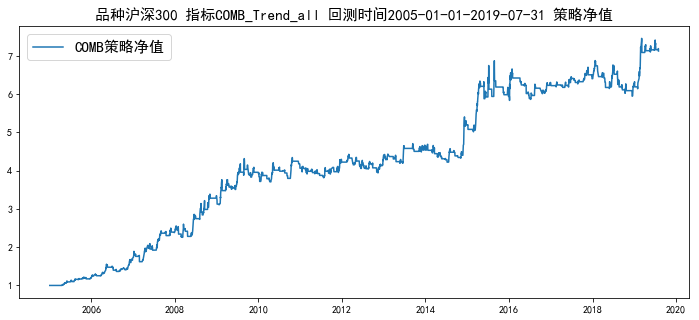

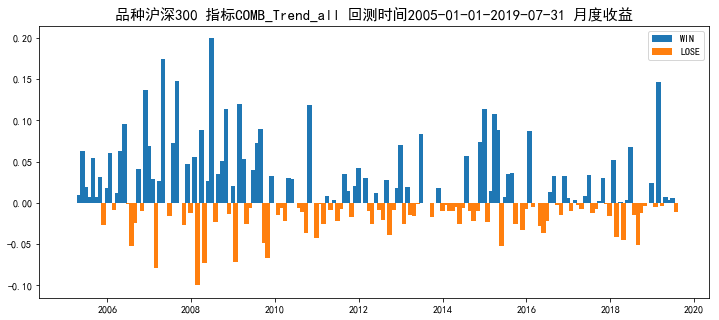

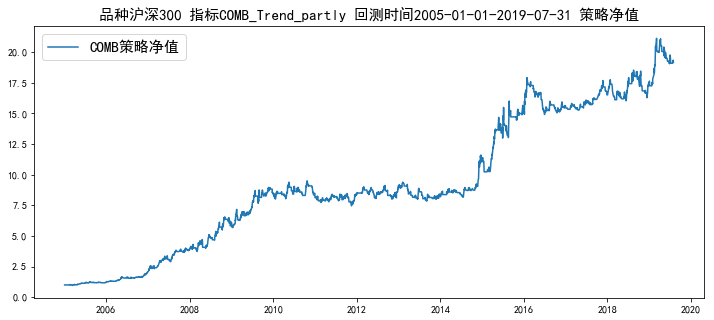

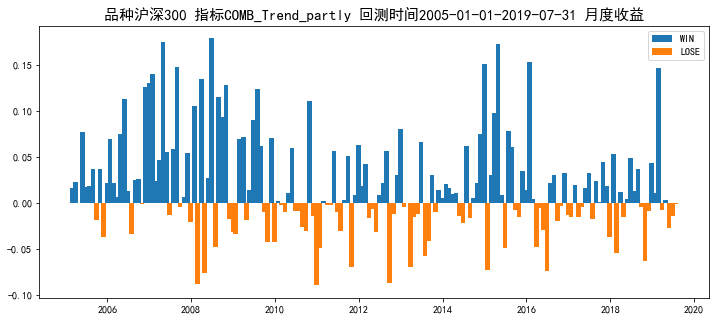

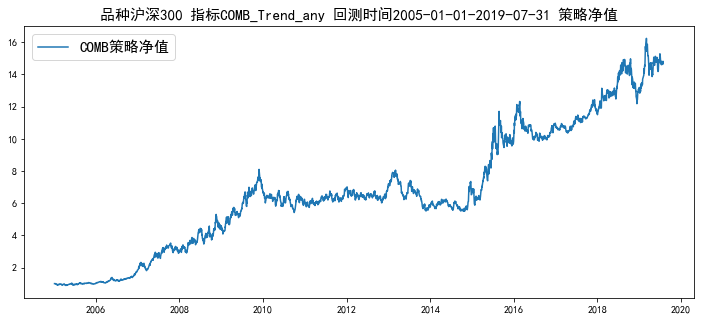

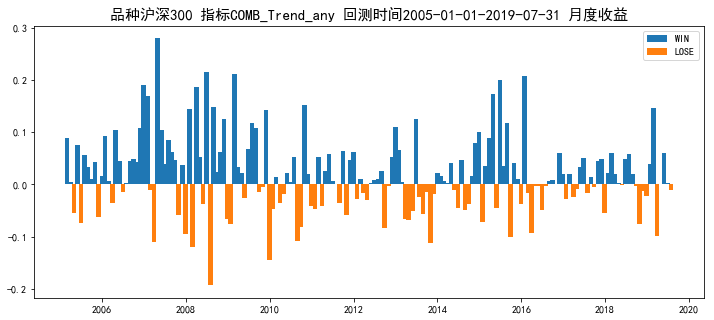

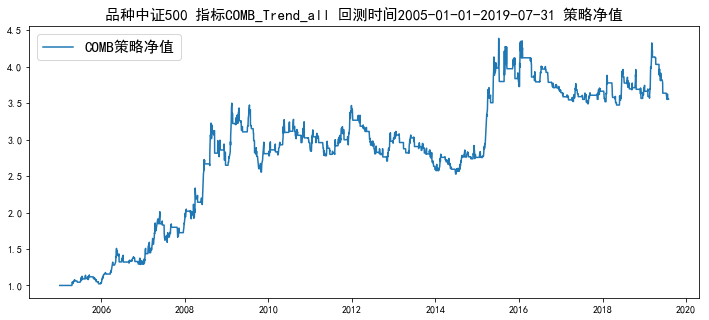

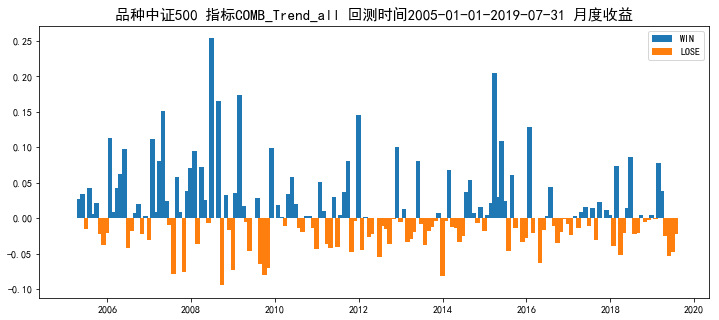

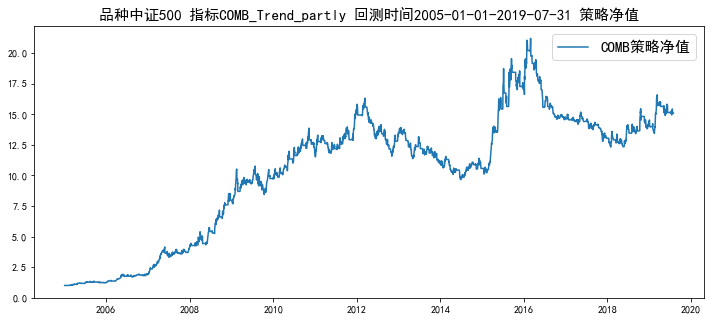

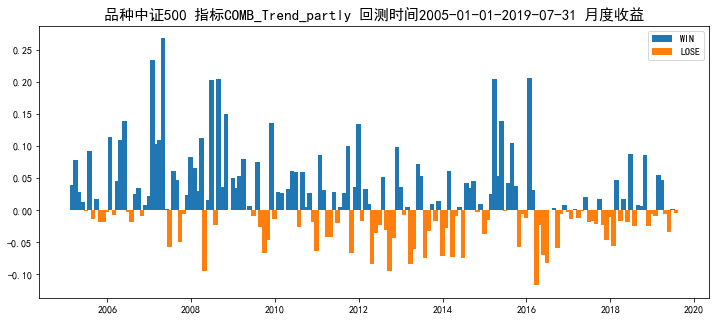

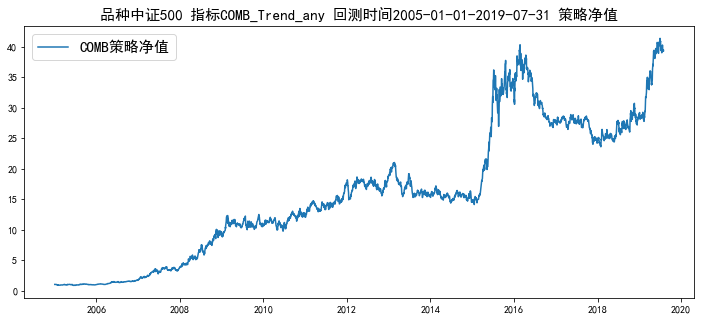

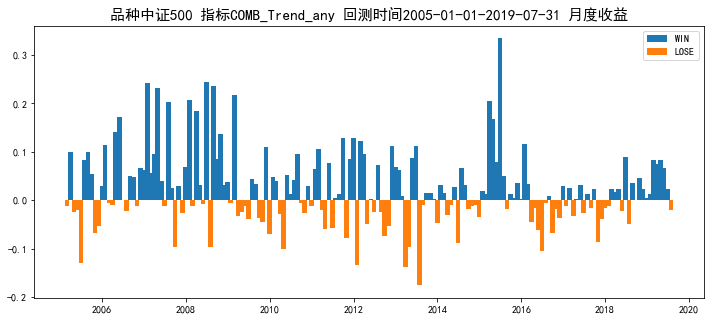

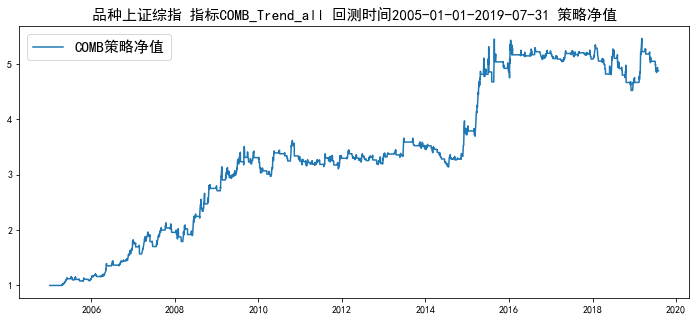

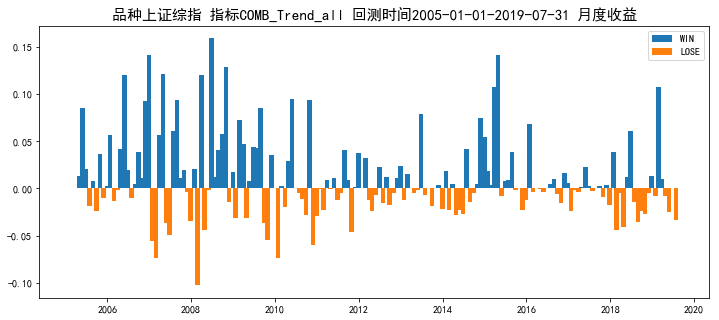

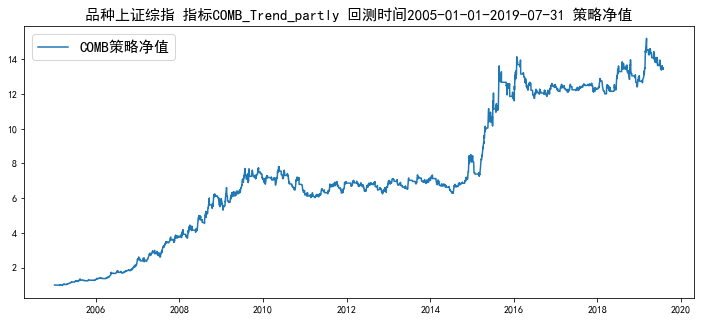

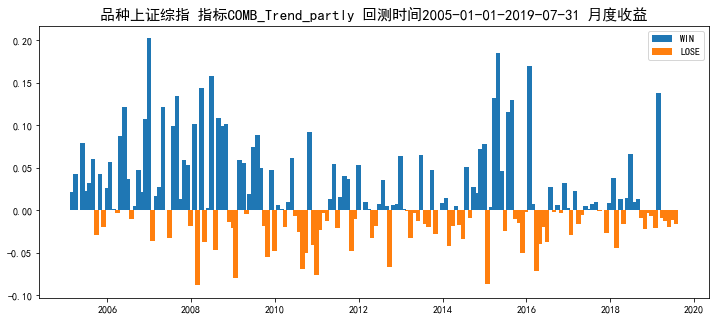

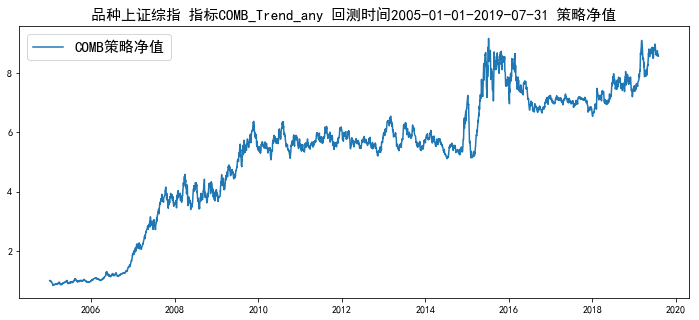

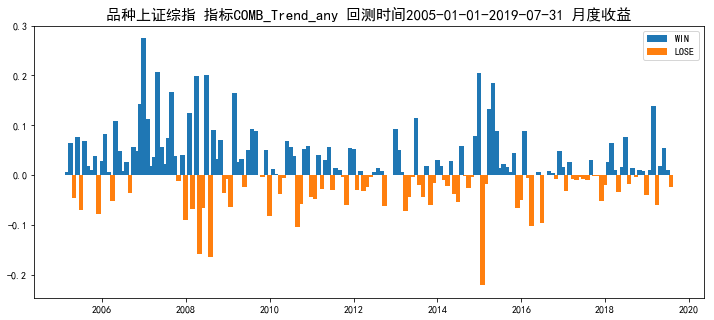

In [211]:
###################### ADJ4 技术指标选择并回测 ######################
Indicator_Dict = {}
TrendIndicator = ['MA','MACD','RSI','SAR','EMA']
InverseIndicator = ['BBANDS']
COMBway = 'Trend' # 'Trend','Inverse'
COMBhowList = ['all','partly','any']

KINDList = ['沪深300','中证500','上证综指']
for KIND in KINDList:
    for COMBhow in COMBhowList:
        INDICATOR_used = 'COMB'
        ######################## 回测 ########################
        ###################### 指标转换接入回测 ######################
        DataForKIND = TaFUN(INDICATOR_used)(PriceData,KIND)
        INDICATOR = 'COMB_%s_%s_signal'%(COMBway,COMBhow)
        DataForKIND_S = DataForKIND.copy()
        DataForKIND_S['Signal'] = DataForKIND_S[INDICATOR]
        DataForKIND_S['dprice'] = DataForKIND_S['收盘价']-DataForKIND_S['收盘价'].shift(1)
        DataForKIND_S['change'] = (DataForKIND_S['Signal'] - DataForKIND_S['Signal'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
        ###################### 储存各类信息 ######################
        dateList = DataForKIND_S['日期'].tolist()
        priceList = DataForKIND_S['收盘价'].tolist()
        combineList = DataForKIND_S['Signal'].tolist()
        changeList = DataForKIND_S['change'].tolist()
        dpriceList = DataForKIND_S['dprice'].tolist()
        ####################### 初始化状态 ######################
        equity = 1
        Nshare = 0
        L = 0
        equityList = []
        ####################### 日循环执行策略 ######################
        strategy_name = ('品种%s 指标%s'%(KIND,INDICATOR))[:-7]
        for dateCnt in range(len(dateList)):
            ## 更新每日信息
            date = dateList[dateCnt]
            date_last = dateList[dateCnt-1]
            price = priceList[dateCnt]
            dprice = dpriceList[dateCnt]
            combine = combineList[dateCnt]
            change = changeList[dateCnt]
            ## 先结算 - 由于信息每日收盘才能得到！
            dequity = Nshare*dprice*L
            if np.isnan(dequity):
                dequity = 0
            equity += dequity
            equityList.append(equity)
            ## 再根据收盘时发出的信号决定是否改变仓位
            if change == 1:
                L = combine
                Nshare = equity/price
        ####################### 回测结果保存 ######################
        equityDf_KIND = pd.DataFrame({'日期':dateList,strategy_name:equityList}).set_index('日期')
        DataForKIND_S_withResult = DataForKIND_S.merge(pd.DataFrame({'日期':dateList,strategy_name:equityList}),on=['日期'])
        ####################### 结果输出 ######################
        # 绘图 #
        ## 净值曲线 ##
        plt.figure(figsize=(12,5))
        plt.plot(equityDf_KIND,label='%s策略净值' %(INDICATOR_used))
        plt.title('%s 回测时间%s-%s 策略净值' %(strategy_name,start,end),fontsize=15)
        plt.legend(loc=0,fontsize=15)
        plt.show()
        ## 月度收益 ##
        equityDf_KIND['日期'] = equityDf_KIND.index
        equityDf_KIND_MonR = equityDf_KIND.apply(lambda x: x.resample('M').last()).set_index('日期').pct_change().dropna()
        equityDf_KIND_MonR_win = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]>0]
        equityDf_KIND_MonR_lose = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]<=0]
        plt.figure(figsize=(12,5))
        plt.bar(equityDf_KIND_MonR_win.index,equityDf_KIND_MonR_win[strategy_name],width=40,label='WIN')
        plt.bar(equityDf_KIND_MonR_lose.index,equityDf_KIND_MonR_lose[strategy_name],width=40,label='LOSE')
        plt.title('%s 回测时间%s-%s 月度收益' %(strategy_name,start,end),fontsize=15)
        plt.legend(loc=0)
        plt.show()
        # 指标 #
        ## 专用指标 ##
        ### 多空切换频率 ##
        LongShortChangeFreq = DataForKIND_S_withResult['change'].sum()/len(DataForKIND_S_withResult)
        New_Indicator = pd.DataFrame([KIND,COMBway,COMBhow,LongShortChangeFreq],index=['品种','类型','投票','多空切换频率'],columns=[strategy_name])
        ## 回测结果评价指标 ##
        Ori_Indicator = Indicator(equityDf_KIND,strategy_name)[0]
        Combine_Indicator = pd.concat([New_Indicator,Ori_Indicator],axis=0)
        Indicator_Dict['%s %s %s'%(KIND,COMBway,COMBhow)] = Combine_Indicator.rename(columns={strategy_name:'%s %s策略 评价指标'%(KIND,INDICATOR_used)})
    #     print(Combine_Indicator)
        print('\n\n')

In [212]:
Indicator_Df = pd.DataFrame()
for eachKey in Indicator_Dict.keys():
    Indicator_Df = pd.concat([Indicator_Df,Indicator_Dict[eachKey]],axis=1)
Indicator_Df_display = Indicator_Df.T
Indicator_Df_display.index = range(len(Indicator_Df_display))
Indicator_Df_display.sort_values(['品种','收益回撤比'],ascending=False)

,品种,类型,投票,多空切换频率,年化收益,年化波动,IR,夏普比率,最大回撤,收益回撤比,最大回撤开始,最大回撤结束,最大回撤持续
1,沪深300,Trend,partly,0.140277,0.224756,0.196366,1.14458,0.9918,0.214774,1.04647,2010-10-25,2011-11-16,1.05955
0,沪深300,Trend,all,0.125318,0.144323,0.158947,0.907995,0.719252,0.150922,0.956275,2015-08-26,2016-01-06,0.364134
2,沪深300,Trend,any,0.0970929,0.202507,0.257239,0.787234,0.670611,0.331168,0.611495,2009-11-27,2010-09-30,0.84052
5,中证500,Trend,any,0.0937059,0.286662,0.290869,0.985538,0.882399,0.414667,0.691307,2016-02-24,2018-01-29,1.93018
4,中证500,Trend,partly,0.146486,0.204737,0.229264,0.893017,0.762163,0.4187,0.488982,2016-02-29,2018-01-29,1.9165
3,中证500,Trend,all,0.141123,0.0910044,0.188865,0.48185,0.323006,0.2778,0.32759,2009-02-16,2014-06-26,5.35524
7,上证综指,Trend,partly,0.149873,0.195134,0.187186,1.04246,0.882195,0.228331,0.854613,2010-05-20,2011-03-30,0.859685
6,上证综指,Trend,all,0.12814,0.114914,0.153811,0.74711,0.552066,0.170243,0.675,2015-08-26,2018-12-03,3.27173
8,上证综指,Trend,any,0.0953994,0.15885,0.243823,0.651497,0.528457,0.290344,0.54711,2015-01-07,2015-02-03,0.073922


## 回测框架 - 技术指标组合使用 - 特定组合

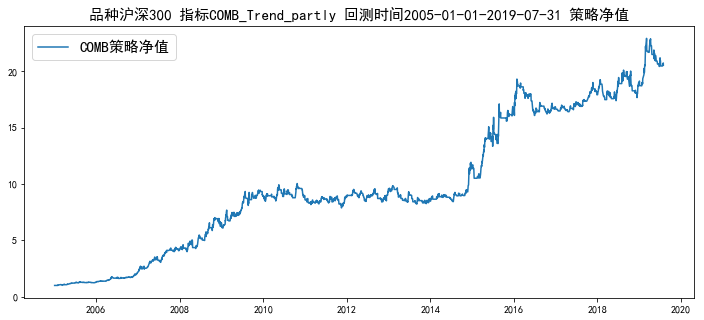

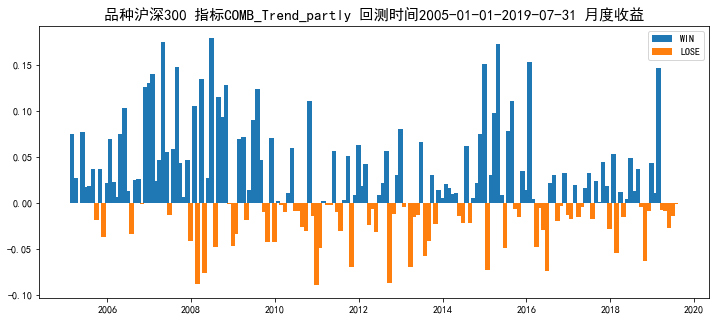

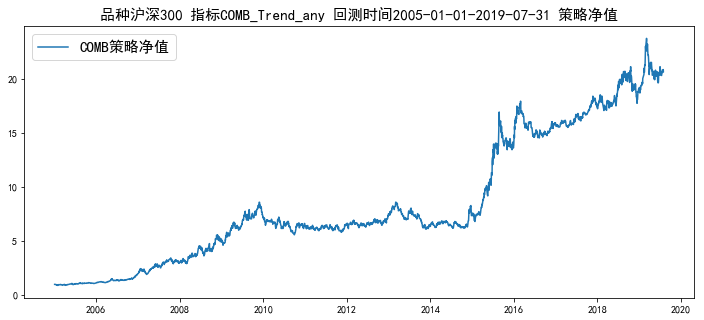

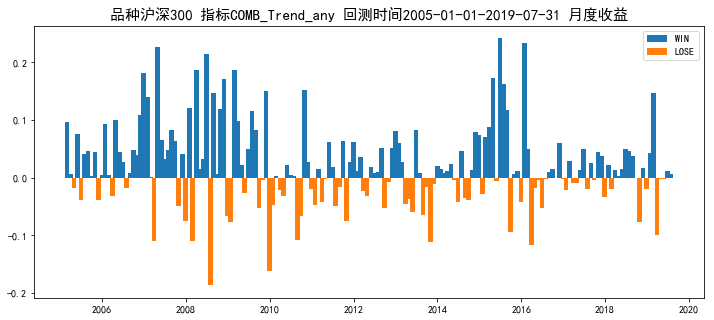

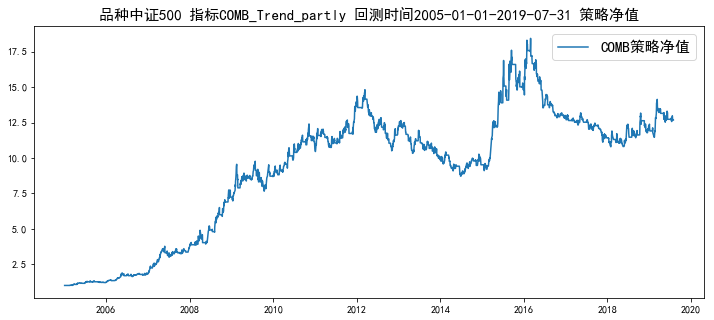

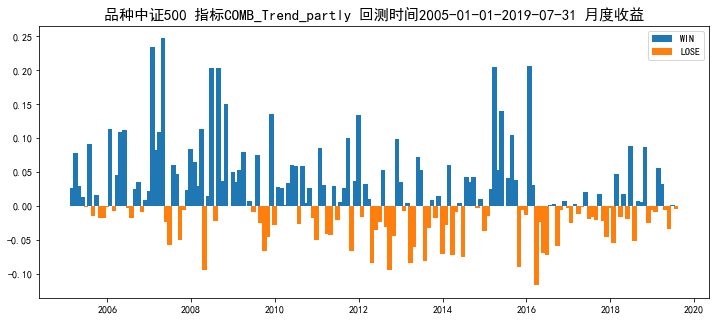

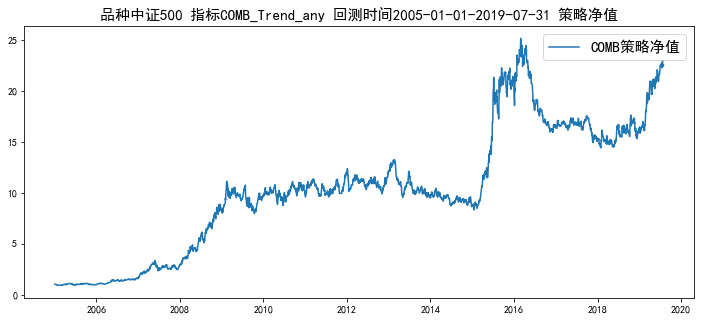

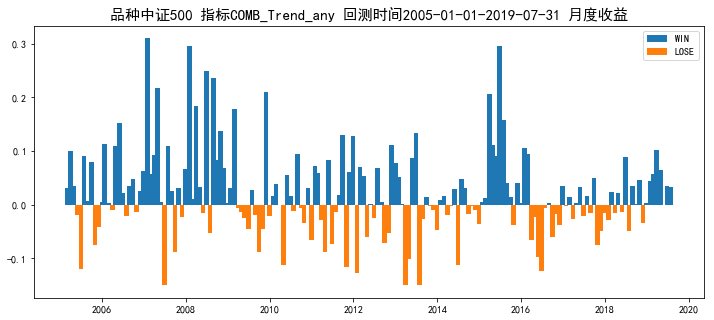

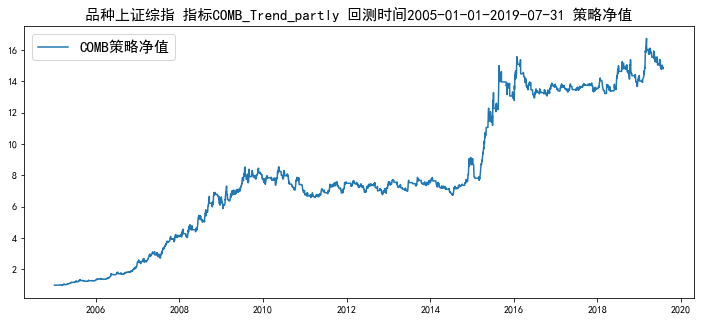

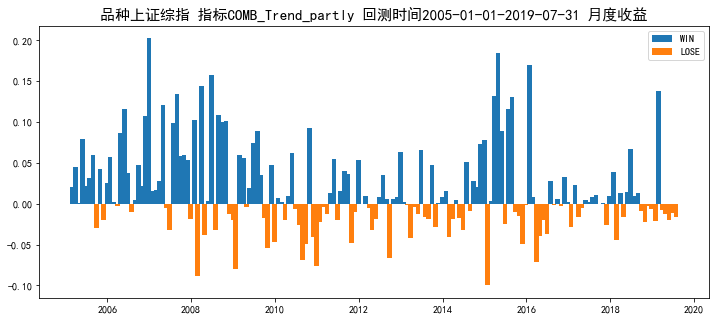

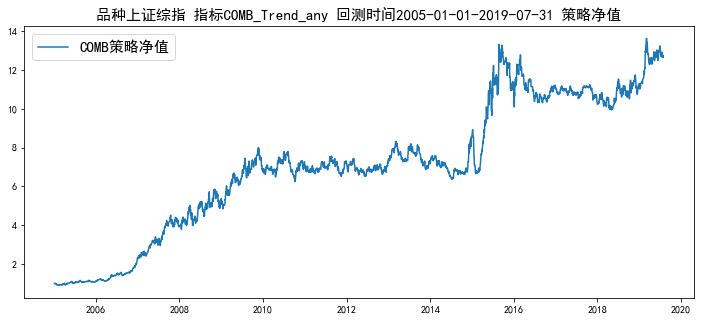

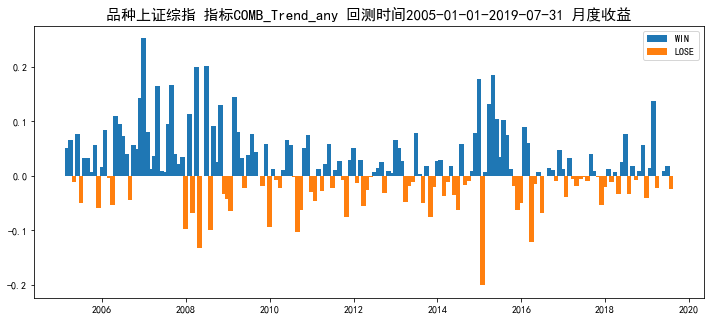

In [209]:
###################### ADJ4 技术指标选择并回测 ######################
Indicator_Dict = {}

TrendIndicator = ['MA','MACD','RSI','SAR','EMA','WILLR']
COMBway= 'Trend' # Only 'Trend','Inverse'

KINDList = ['沪深300','中证500','上证综指']
for KIND in KINDList:
    for COMBhow in ['all','partly','any']:
        INDICATOR_used = 'COMB'
        ######################## 回测 ########################
        ###################### 指标转换接入回测 ######################
        DataForKIND = TaFUN(INDICATOR_used)(PriceData,KIND)
        INDICATOR = 'COMB_%s_%s_signal'%(COMBway,COMBhow)
        if len(DataForKIND[DataForKIND[INDICATOR]==0])/len(DataForKIND) > 0.8:
            continue
        DataForKIND_S = DataForKIND.copy()
        DataForKIND_S['Signal'] = DataForKIND_S[INDICATOR]
        DataForKIND_S['dprice'] = DataForKIND_S['收盘价']-DataForKIND_S['收盘价'].shift(1)
        DataForKIND_S['change'] = (DataForKIND_S['Signal'] - DataForKIND_S['Signal'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
        ###################### 储存各类信息 ######################
        dateList = DataForKIND_S['日期'].tolist()
        priceList = DataForKIND_S['收盘价'].tolist()
        combineList = DataForKIND_S['Signal'].tolist()
        changeList = DataForKIND_S['change'].tolist()
        dpriceList = DataForKIND_S['dprice'].tolist()
        ####################### 初始化状态 ######################
        equity = 1
        Nshare = 0
        L = 0
        equityList = []
        ####################### 日循环执行策略 ######################
        strategy_name = ('品种%s 指标%s'%(KIND,INDICATOR))[:-7]
        for dateCnt in range(len(dateList)):
            ## 更新每日信息
            date = dateList[dateCnt]
            date_last = dateList[dateCnt-1]
            price = priceList[dateCnt]
            dprice = dpriceList[dateCnt]
            combine = combineList[dateCnt]
            change = changeList[dateCnt]
            ## 先结算 - 由于信息每日收盘才能得到！
            dequity = Nshare*dprice*L
            if np.isnan(dequity):
                dequity = 0
            equity += dequity
            equityList.append(equity)
            ## 再根据收盘时发出的信号决定是否改变仓位
            if change == 1:
                L = combine
                Nshare = equity/price
        ####################### 回测结果保存 ######################
        equityDf_KIND = pd.DataFrame({'日期':dateList,strategy_name:equityList}).set_index('日期')
        DataForKIND_S_withResult = DataForKIND_S.merge(pd.DataFrame({'日期':dateList,strategy_name:equityList}),on=['日期'])
        ####################### 结果输出 ######################
        # 绘图 #
        ## 净值曲线 ##
        plt.figure(figsize=(12,5))
        plt.plot(equityDf_KIND,label='%s策略净值' %(INDICATOR_used))
        plt.title('%s 回测时间%s-%s 策略净值' %(strategy_name,start,end),fontsize=15)
        plt.legend(loc=0,fontsize=15)
        plt.show()
        ## 月度收益 ##
        equityDf_KIND['日期'] = equityDf_KIND.index
        equityDf_KIND_MonR = equityDf_KIND.apply(lambda x: x.resample('M').last()).set_index('日期').pct_change().dropna()
        equityDf_KIND_MonR_win = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]>0]
        equityDf_KIND_MonR_lose = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]<=0]
        plt.figure(figsize=(12,5))
        plt.bar(equityDf_KIND_MonR_win.index,equityDf_KIND_MonR_win[strategy_name],width=40,label='WIN')
        plt.bar(equityDf_KIND_MonR_lose.index,equityDf_KIND_MonR_lose[strategy_name],width=40,label='LOSE')
        plt.title('%s 回测时间%s-%s 月度收益' %(strategy_name,start,end),fontsize=15)
        plt.legend(loc=0)
        plt.show()
        # 指标 #
        ## 专用指标 ##
        ### 多空切换频率 ##
        LongShortChangeFreq = DataForKIND_S_withResult['change'].sum()/len(DataForKIND_S_withResult)
        New_Indicator = pd.DataFrame([KIND,COMBway,COMBhow,LongShortChangeFreq],index=['品种','类型','投票','多空切换频率'],columns=[strategy_name])
        ## 回测结果评价指标 ##
        Ori_Indicator = Indicator(equityDf_KIND,strategy_name)[0]
        Combine_Indicator = pd.concat([New_Indicator,Ori_Indicator],axis=0)
        Indicator_Dict['%s %s %s'%(KIND,COMBway,COMBhow)] = Combine_Indicator.rename(columns={strategy_name:'%s %s策略 评价指标'%(KIND,INDICATOR_used)})
    #     print(Combine_Indicator)
        print('\n\n')

In [213]:
Indicator_Df = pd.DataFrame()
for eachKey in Indicator_Dict.keys():
    Indicator_Df = pd.concat([Indicator_Df,Indicator_Dict[eachKey]],axis=1)
Indicator_Df_display = Indicator_Df.T
Indicator_Df_display.index = range(len(Indicator_Df_display))
Indicator_Df_display.sort_values(['品种','收益回撤比'],ascending=False)

,品种,指标,多空切换频率,年化收益,年化波动,IR,夏普比率,最大回撤,收益回撤比,最大回撤开始,最大回撤结束,最大回撤持续
4,沪深300,BBANDS,0.120802,0.0662148,0.0708587,0.934463,0.511085,0.0942158,0.702799,2007-06-04,2007-07-06,0.0876112
5,沪深300,EMA,0.0158058,0.241274,0.238965,1.00966,0.884121,0.362221,0.666094,2009-08-03,2014-07-22,4.96646
0,沪深300,MA,0.023991,0.220355,0.240013,0.918097,0.793103,0.411183,0.535904,2009-08-03,2010-04-20,0.711841
9,沪深300,CCIEX,0.169913,0.129919,0.184598,0.703793,0.541278,0.289329,0.449035,2009-08-19,2011-12-07,2.29979
3,沪深300,SAR,0.0894722,0.151968,0.262365,0.579224,0.464879,0.39891,0.380958,2010-08-11,2014-11-24,4.28747
1,沪深300,MACD,0.0677392,0.149075,0.260891,0.571406,0.456416,0.418042,0.356603,2008-02-01,2008-05-20,0.298426
2,沪深300,RSI,0.178662,0.0734466,0.262024,0.280305,0.165811,0.381034,0.192756,2015-07-08,2018-12-14,3.436
8,沪深300,CCI,0.161445,0.09627,0.265257,0.362931,0.249833,0.543835,0.177021,2008-01-22,2012-07-24,4.50376
7,沪深300,WILLRK,0.0733841,0.0192544,0.0820633,0.234628,-0.130943,0.183501,0.104928,2007-11-16,2008-10-16,0.91718
6,沪深300,WILLR,0.259385,-0.128437,0.217512,-0.590481,-0.728405,0.890247,-0.144271,2005-02-21,2019-05-09,14.2094


# 探究 - 原始均线与卷积均线计算

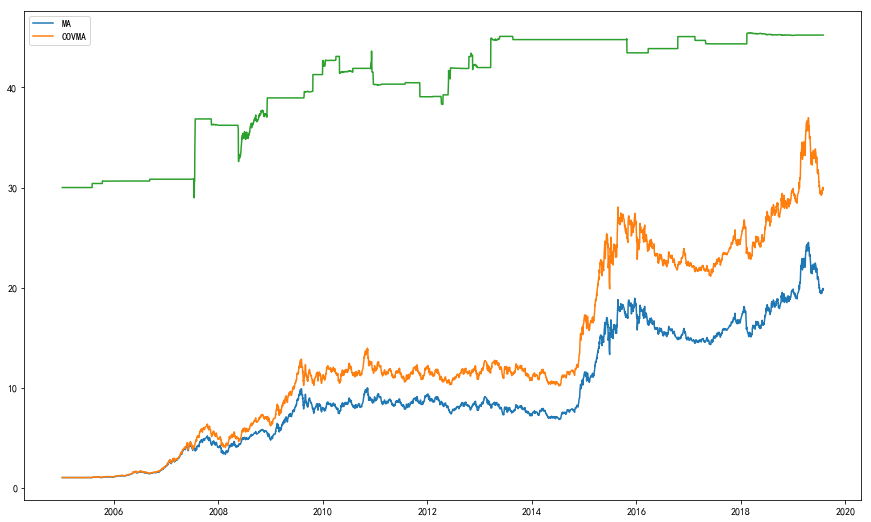

In [623]:
plt.figure(figsize=(15,9))
plt.plot(MADF,label='MA')
plt.plot(COVMADF,label='COVMA')
plt.legend(loc=0)
plt.plot(COVMADF.iloc[:,0]/MADF.iloc[:,0]*30)

In [624]:
print(classification_report(MACloseDataForKIND['MA10_MA60_signal'].dropna(),COVMACloseDataForKIND['COVMA10_COVMA60_signal'].dropna()))

              precision    recall  f1-score   support

        -1.0       1.00      0.97      0.98      1640
         1.0       0.97      1.00      0.98      1844

   micro avg       0.98      0.98      0.98      3484
   macro avg       0.99      0.98      0.98      3484
weighted avg       0.98      0.98      0.98      3484



In [625]:
np.corrcoef(MACloseDataForKIND['MA10_MA60_signal'].dropna(),COVMACloseDataForKIND['COVMA10_COVMA60_signal'].dropna(),'spearman')

array([[1.       , 0.9676269],
       [0.9676269, 1.       ]])

In [632]:
ddd = pd.DataFrame([MACloseDataForKIND['MA10_MA60_signal'].dropna(),COVMACloseDataForKIND['COVMA10_COVMA60_signal'].dropna()]).T
ddd.apply(lambda x: 1 if x['MA10_MA60_signal'] != x['COVMA10_COVMA60_signal'] else 0,axis=1).sum()/len(ddd)

0.016360505166475317